# Мастерска 2 - Прогнозирование вероятности совершения покупки.
<a id='head'></a>

## Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель**:

Разработать модель предсказания вероятности совершения покупки.

**Задачи**:

* Изучить данные
* Разработать полезные признаки
* Создать модель для классификации пользователей
* Улучшить модель и максимизировать метрику roc_auc
* Выполнить тестирование

In [1]:
#!pip install phik -q
#!pip install shap -q
#!pip install category_encoders -q
#!pip install lightgbm -q
#!pip install --upgrade scikit-learn -q
#!pip install catboost -q

## Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import pylab
import scipy.stats as stats
from scipy.stats import shapiro
from datetime import datetime, timedelta

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     RandomizedSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import (recall_score,
                             precision_score,
                             accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_curve,
                             roc_auc_score,
                             f1_score
                             )
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   OneHotEncoder, 
                                   FunctionTransformer)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import (SimpleImputer,
                            KNNImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

import missingno as msno
import warnings
import random
from itertools import chain
import ast
import re
import phik
import shap
import os

warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(12, 12)})

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

RANDOM_STATE = 15
TEST_SIZE = 0.25

DATA_PATH = '/kaggle/input/customer-return/'

## Загрузка данных

In [3]:
df_purchas = pd.read_csv(os.path.join(DATA_PATH, 'apparel-purchases.csv'), parse_dates=['date'])
df_messages = pd.read_csv(os.path.join(DATA_PATH, 'apparel-messages.csv'), parse_dates=['date', 'created_at'])
df_target = pd.read_csv(os.path.join(DATA_PATH,'apparel-target_binary.csv'))

In [4]:
df_purchas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [5]:
df_purchas.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.00,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.00,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.00,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.00,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.00,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


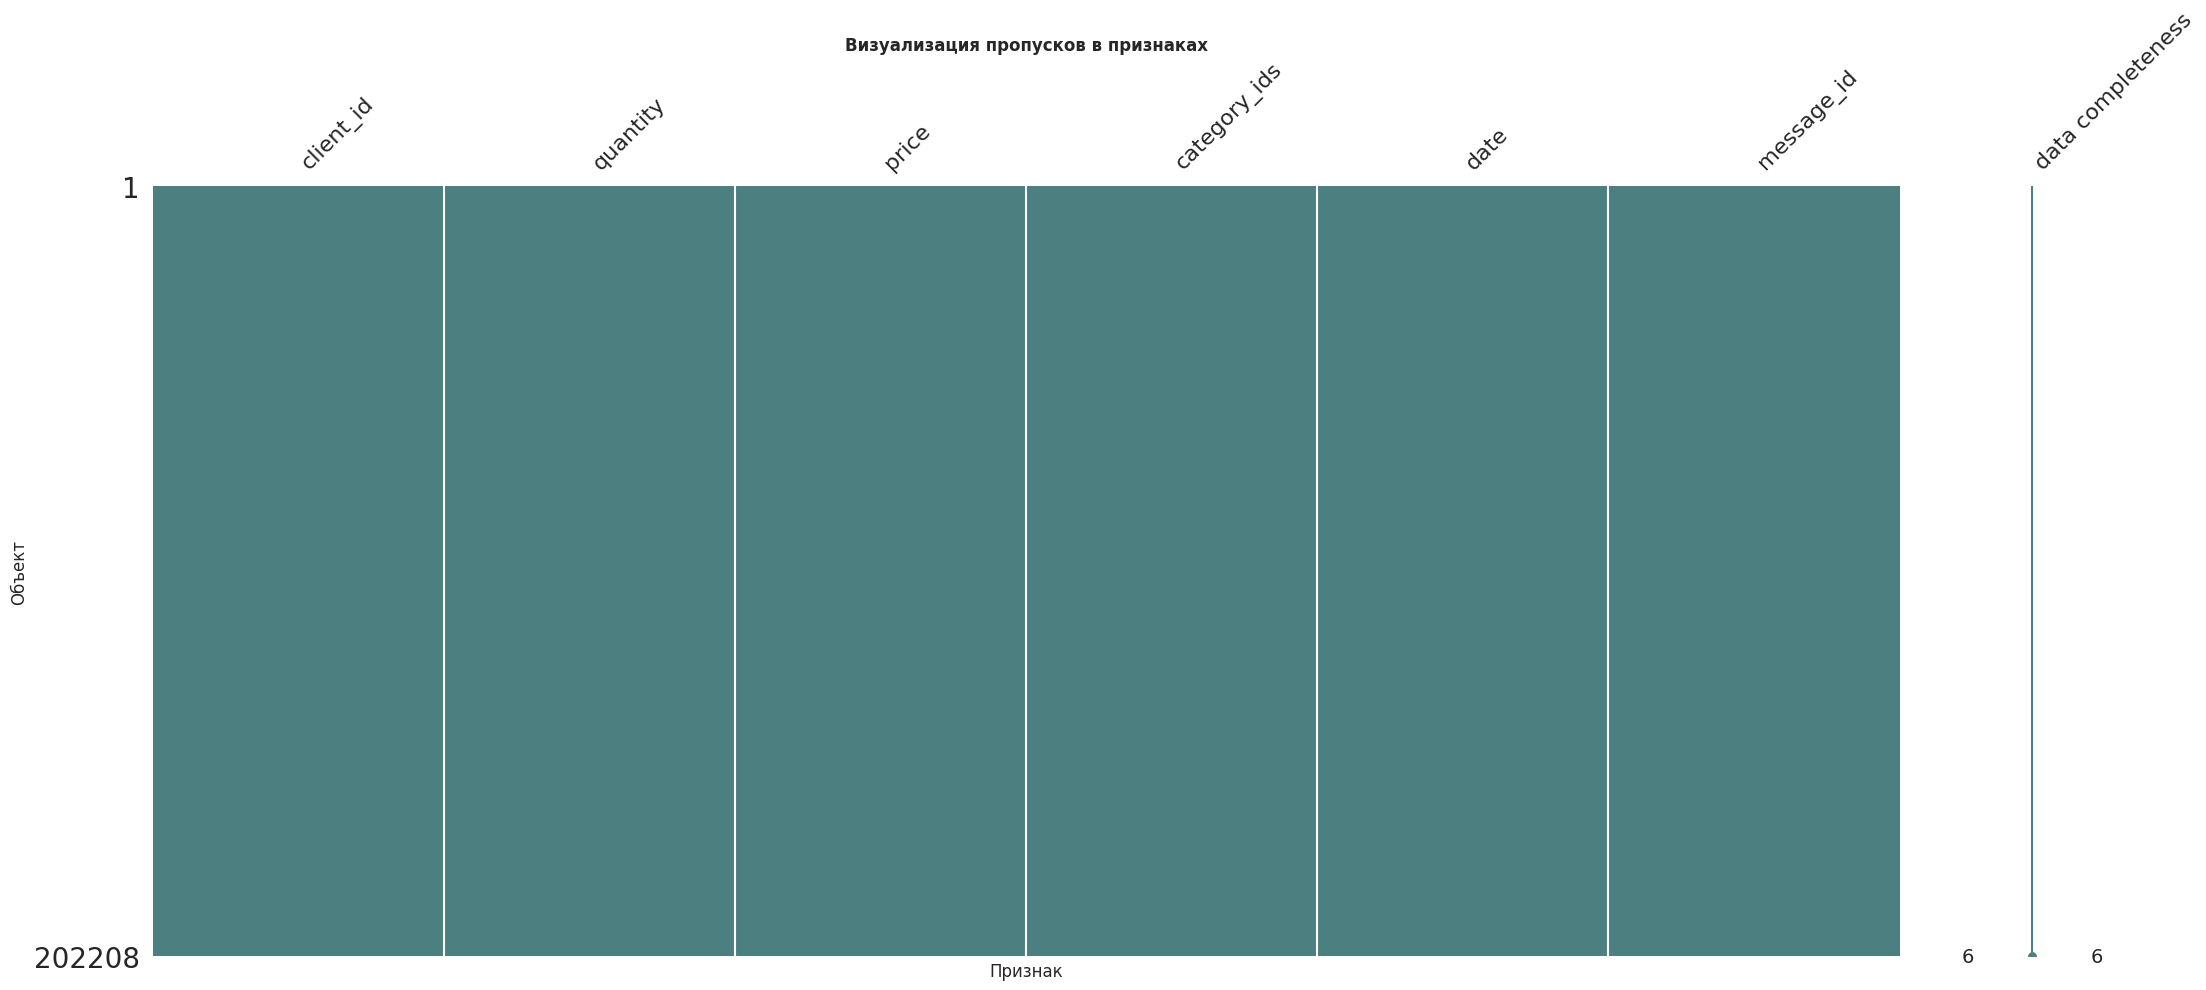

In [6]:
msno.matrix(df_purchas, labels=True, color=(0.3, 0.5, 0.5))
plt.title('Визуализация пропусков в признаках', weight='bold')
plt.ylabel('Объект')
plt.xlabel('Признак')
plt.show()

Пропущенных значение нет.

In [7]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [8]:
df_messages.head(20)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


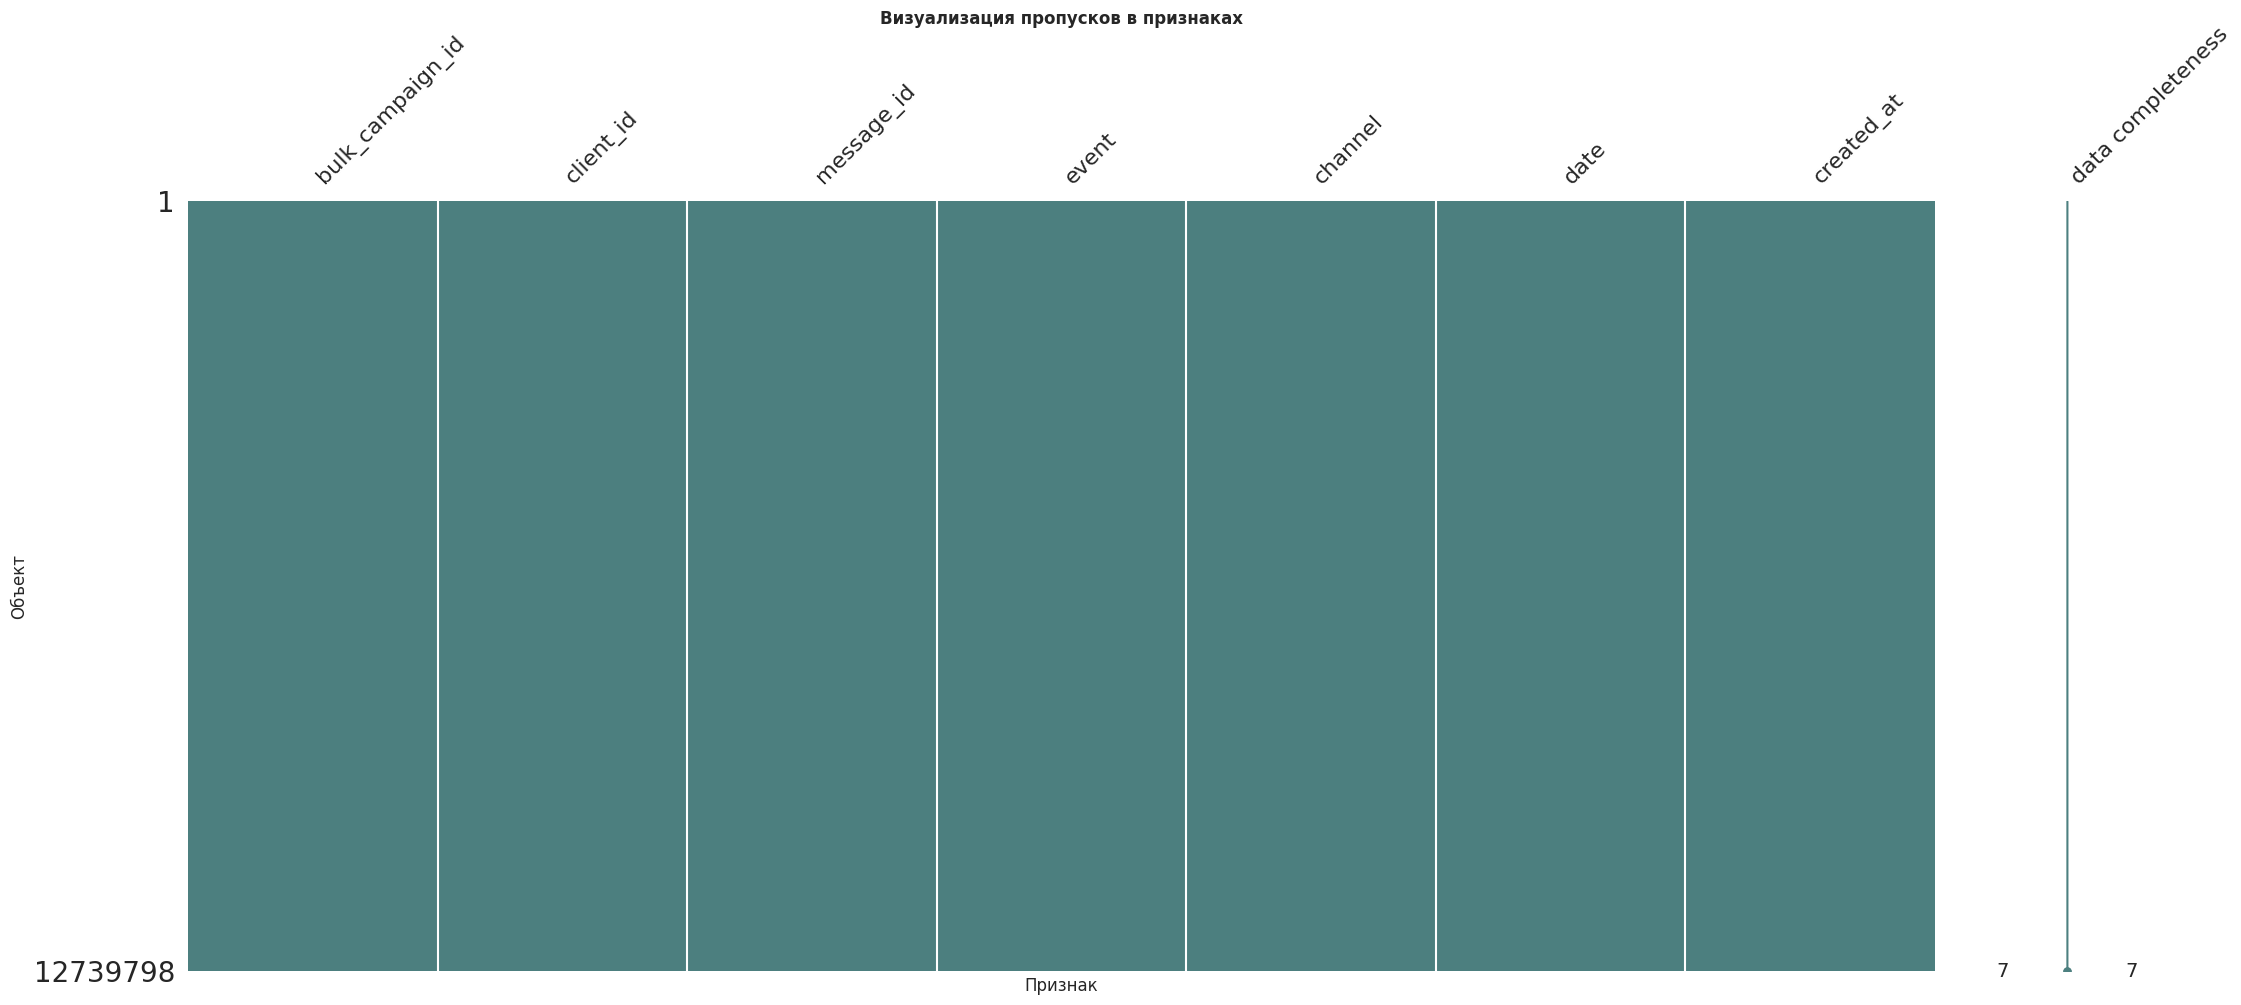

In [9]:
msno.matrix(df_messages, labels=True, color=(0.3, 0.5, 0.5))
plt.title('Визуализация пропусков в признаках', weight='bold')
plt.ylabel('Объект')
plt.xlabel('Признак')
plt.show()

Пропущенных значений нет.

In [10]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [11]:
df_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


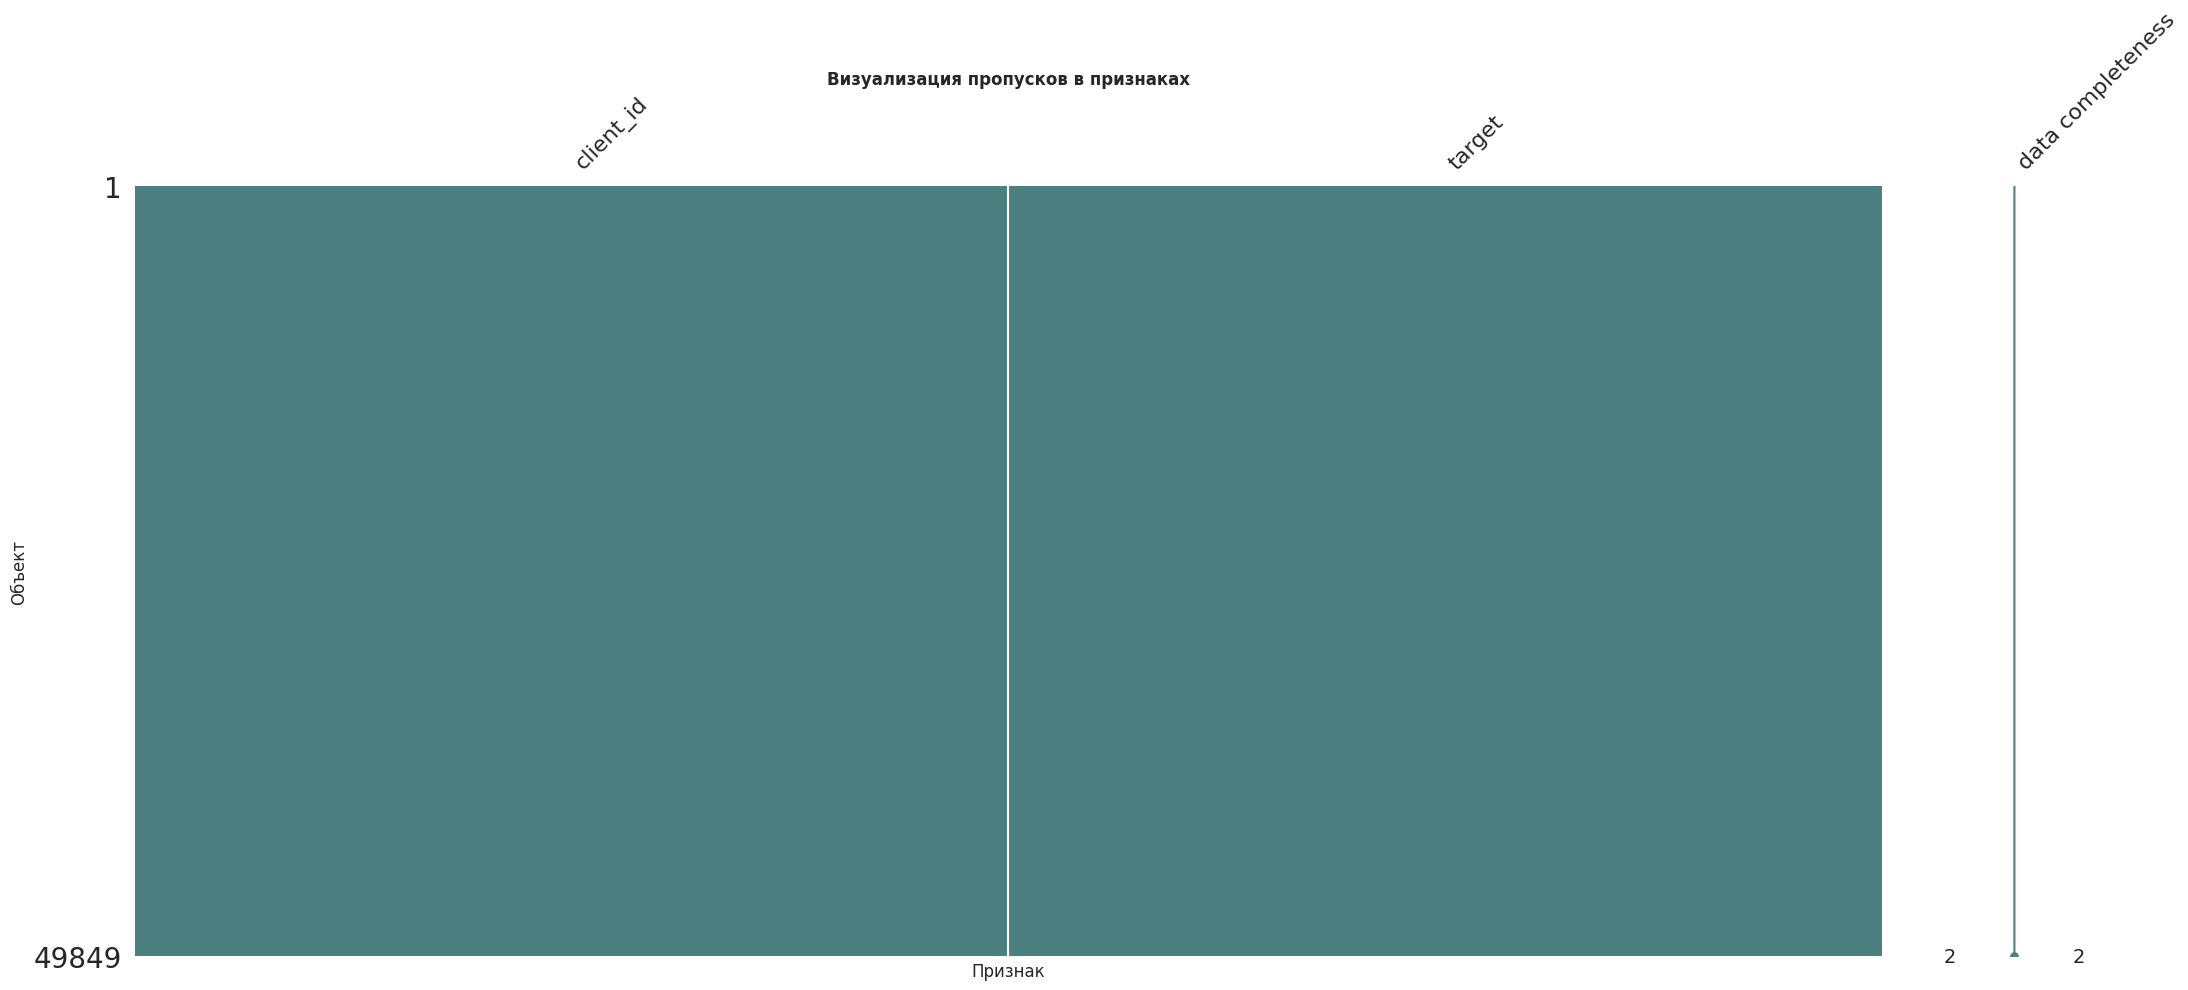

In [12]:
msno.matrix(df_target, labels=True, color=(0.3, 0.5, 0.5))
plt.title('Визуализация пропусков в признаках', weight='bold')
plt.ylabel('Объект')
plt.xlabel('Признак')
plt.show()

Пропущенных значений нет.

## Исследовательнский анализ и создание признаков

In [13]:
df_purchas_pivot = pd.pivot_table(df_purchas, values=['quantity' , 'price'], index=['client_id'], aggfunc="sum").reset_index()

In [14]:
df_purchas_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  49849 non-null  int64  
 1   price      49849 non-null  float64
 2   quantity   49849 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 1.1 MB


In [15]:
df_purchas_pivot.client_id.duplicated().sum()

0

После агрегации по client_id получилось 49849 строк, также как и в файле с целевым признаком. Соответственно дупликатов нет.

### UDF

In [16]:
def cat_vis(df, cat):
    sns.barplot(x=df[cat].value_counts().index,
                y=df[cat].value_counts(),
                #data=df,
               )
    plt.title(f'График распределения {cat}', weight='bold')
    plt.xlabel('Кол-во вернувшихся покупателей')
    plt.show()
    return df[cat].value_counts()

In [17]:
def numeric_analysis(df, column, annot):
    # выводим таблицу со статистикой и считаем усы боксплота
    stat = df[column].describe()
    print(stat)
    up_whisker = stat['75%'] + 1.5 * (stat['75%'] - stat['25%'])
    low_whisker = stat['25%'] - 1.5 * (stat['75%'] - stat['25%'])

    print(f'\nВерхний ус: {round(up_whisker, 2)} \nНижний ус: {round(low_whisker, 2)} \
    \nМедианное значение: {df[column].median()}')

    # строим ящик с усами и гистограмму признака
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], orient="h", ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist, bins=100, kde=True)
    plt.axvline(df[column].mean(), color='r', linestyle='-', label=f'Среднее значение: {round(df[column].mean(), 2)}')
    plt.axvline(df[column].median(), color='g', linestyle='--', label=f'Медианное значение: {round(df[column].median(), 2)}')
    ax_box.set(xlabel='')
    ax_hist.legend(loc='best')
    ax_box.set_title(f'График распределения {annot}', weight='bold')
    plt.show()

count   202208.00
mean         1.01
std          0.18
min          1.00
25%          1.00
50%          1.00
75%          1.00
max         30.00
Name: quantity, dtype: float64

Верхний ус: 1.0 
Нижний ус: 1.0     
Медианное значение: 1.0


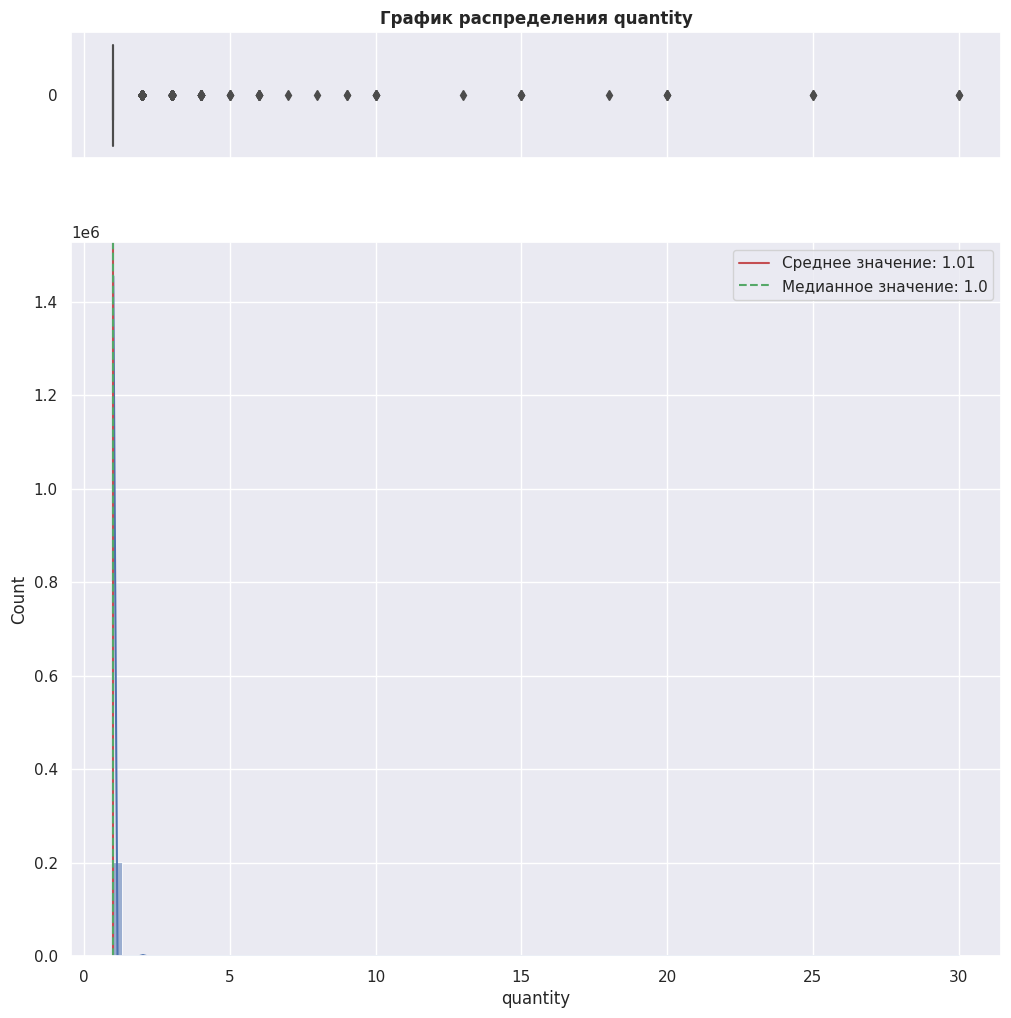

In [18]:
numeric_analysis(df_purchas, 'quantity', 'quantity')

Делалсь в основном 1 покупка. 

In [19]:
df_purchas[df_purchas['quantity'] == 30]

,client_id,quantity,price,category_ids,date,message_id
37005,1515915625548883766,30,2.00,"['5562', '5597', '5691', '889']",2022-09-06,1515915625548883766-6283-6316e248bbbf9
158373,1515915625594593699,30,2.00,"['5562', '5597', '5691', '889']",2023-07-12,1515915625468268596-13482-64ae724c9316b


count   202208.00
mean      1193.30
std       1342.25
min          1.00
25%        352.00
50%        987.00
75%       1699.00
max      85499.00
Name: price, dtype: float64

Верхний ус: 3719.5 
Нижний ус: -1668.5     
Медианное значение: 987.0


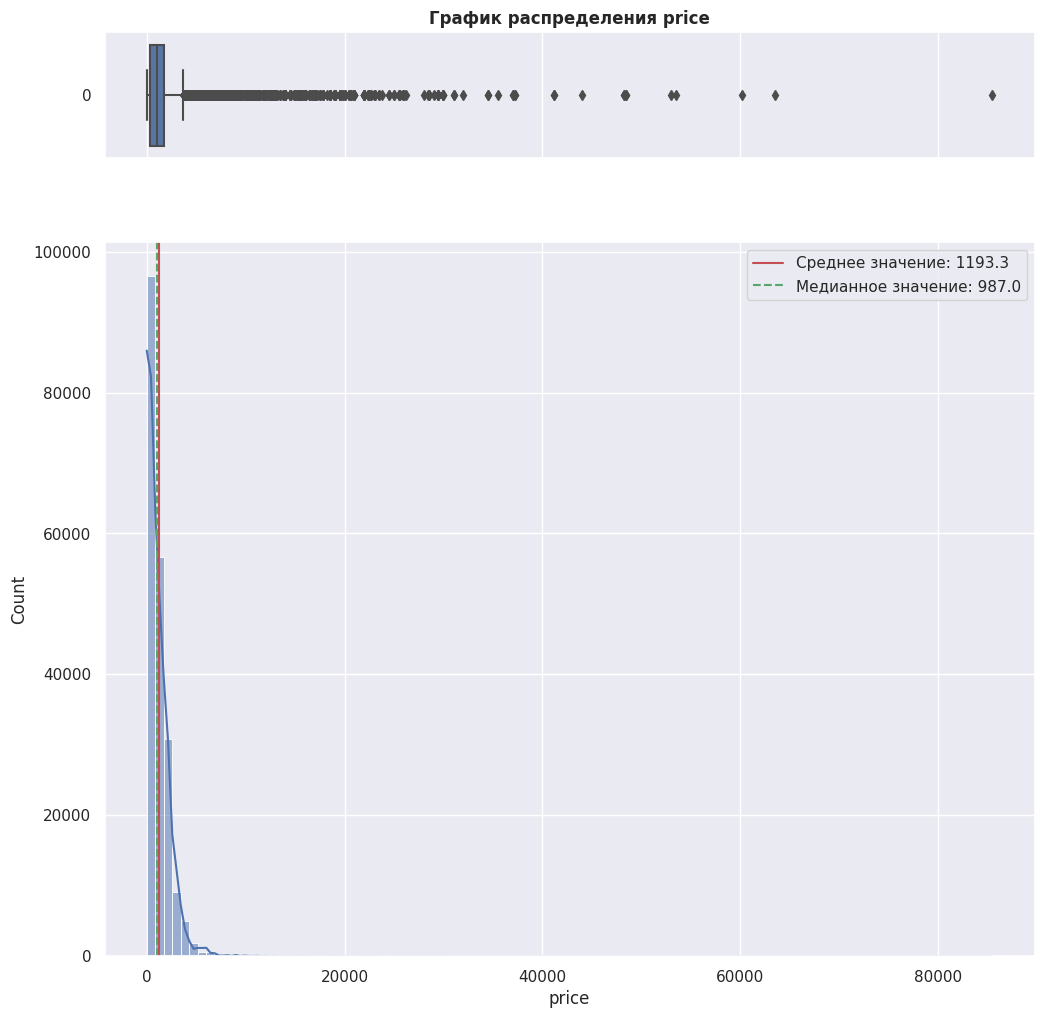

In [20]:
numeric_analysis(df_purchas, 'price', 'price')

Основные суммы покупок сконцентрированы между 352 и 1699 у.е.

In [21]:
df_purchas[df_purchas['price'] > 80000]

,client_id,quantity,price,category_ids,date,message_id
186736,1515915625553309277,1,85499.00,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711


In [22]:
df_purchas[df_purchas['price'] == 1]

,client_id,quantity,price,category_ids,date,message_id
22153,1515915625558323436,1,1.00,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.00,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
32063,1515915625490679651,1,1.00,"['4', '28', '44', '1594']",2022-08-19,1515915625490679651-5922-62ff354e68cd3
32064,1515915625490679651,1,1.00,"['4', '28', '44', '1594']",2022-08-19,1515915625490679651-5922-62ff354e68cd3
32283,1515915625578652401,1,1.00,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
...,...,...,...,...,...,...
198702,1515915625615134152,1,1.00,"['2', '18', '61', '660']",2024-02-02,1515915625615134152-14590-65bcac271717b
199509,1515915625505063729,1,1.00,[],2024-02-08,1515915625505063729-14582-65bb5a2b9adcc
199510,1515915625505063729,1,1.00,[],2024-02-08,1515915625505063729-14582-65bb5a2b9adcc
201246,1515915625558967191,1,1.00,[],2024-02-14,1515915625980158750-14649-65cca1c3cc334


In [23]:
# средняя цена покупки
df_purchas_pivot['mean_price'] = df_purchas_pivot['price'] / df_purchas_pivot['quantity']
# общая сумма покупок
df_purchas_pivot['total_price'] = df_purchas_pivot['price'] * df_purchas_pivot['quantity']

In [24]:
df_purchas_pivot.rename(columns={'price': 'sum_price',
                                      'quantity': 'sum_quantity'}, inplace=True)
df_purchas_pivot

,client_id,sum_price,sum_quantity,mean_price,total_price
0,1515915625468060902,6993.00,7,999.00,48951.00
1,1515915625468061003,16235.00,7,2319.29,113645.00
2,1515915625468061099,299.00,1,299.00,299.00
3,1515915625468061100,2098.00,2,1049.00,4196.00
4,1515915625468061170,33601.00,19,1768.47,638419.00
...,...,...,...,...,...
49844,1515915626010261344,8994.00,6,1499.00,53964.00
49845,1515915626010266132,1818.00,2,909.00,3636.00
49846,1515915626010439406,198.00,2,99.00,396.00
49847,1515915626010443527,1999.00,1,1999.00,1999.00


count      49849.00
mean       41406.94
std       485376.93
min            1.00
25%         2199.00
50%         6996.00
75%        23391.00
max     94194280.00
Name: total_price, dtype: float64

Верхний ус: 55179.0 
Нижний ус: -29589.0     
Медианное значение: 6996.0


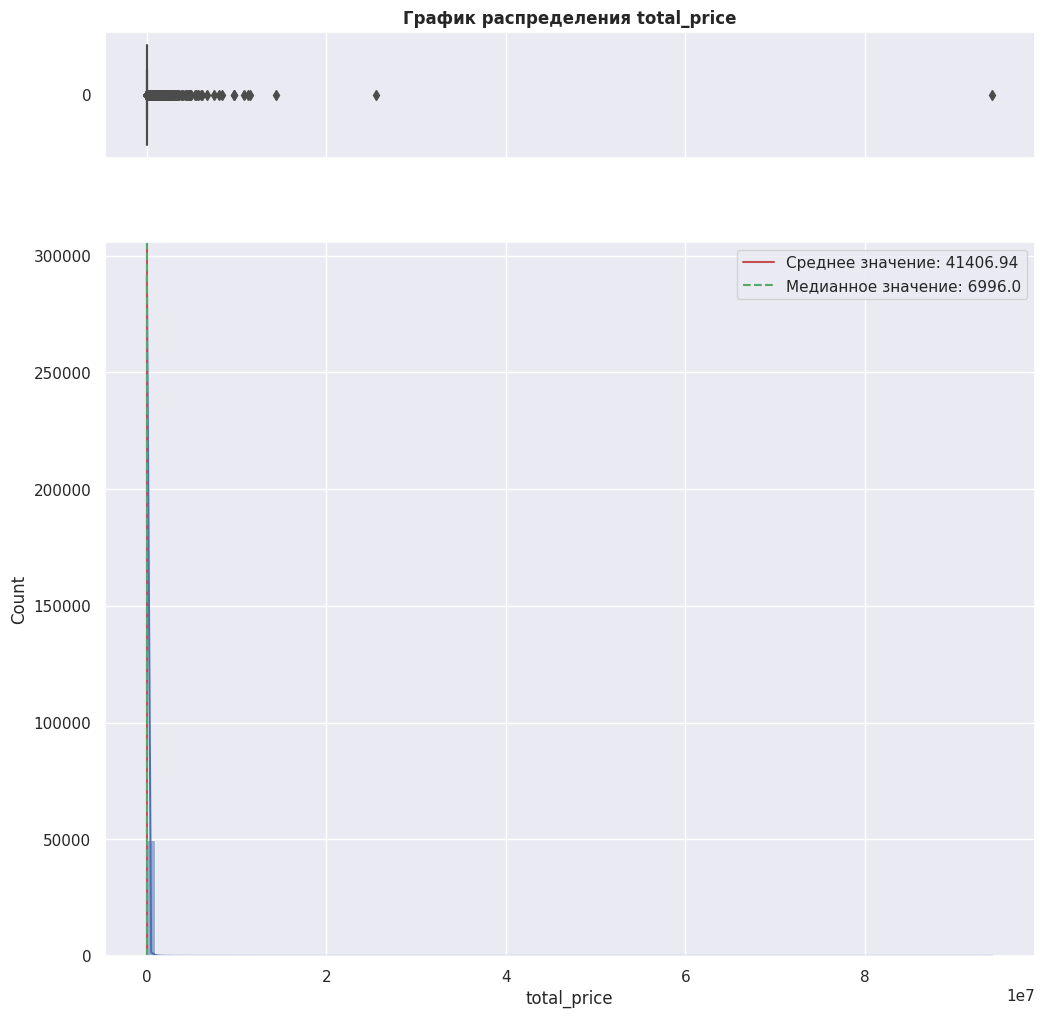

In [25]:
numeric_analysis(df_purchas_pivot, 'total_price', 'total_price')

* Есть очень богатый покупатель. Купил на 94 млн.
* Общие суммы покупок в основном находятся между 2199 и 23391 у.е.

In [26]:
df_purchas_price_grouped = df_purchas.groupby('client_id')['price'].agg(['min', 'max']).reset_index()

In [27]:
df_purchas_price_grouped.rename(columns = {'min': 'min_price',
                                           'max': 'max_price'}, inplace=True)

In [28]:
df_purchas_price_grouped['diff_min_max_price'] = df_purchas_price_grouped['max_price'] - df_purchas_price_grouped['min_price']

In [29]:
df_purchas_price_grouped.head()

,client_id,min_price,max_price,diff_min_max_price
0,1515915625468060902,199.00,1999.00,1800.00
1,1515915625468061003,1749.00,3499.00,1750.00
2,1515915625468061099,299.00,299.00,0.00
3,1515915625468061100,1049.00,1049.00,0.00
4,1515915625468061170,7.00,2699.00,2692.00


count   49849.00
mean     1792.13
std      1647.32
min         1.00
25%       910.00
50%      1499.00
75%      2199.00
max     85499.00
Name: max_price, dtype: float64

Верхний ус: 4132.5 
Нижний ус: -1023.5     
Медианное значение: 1499.0


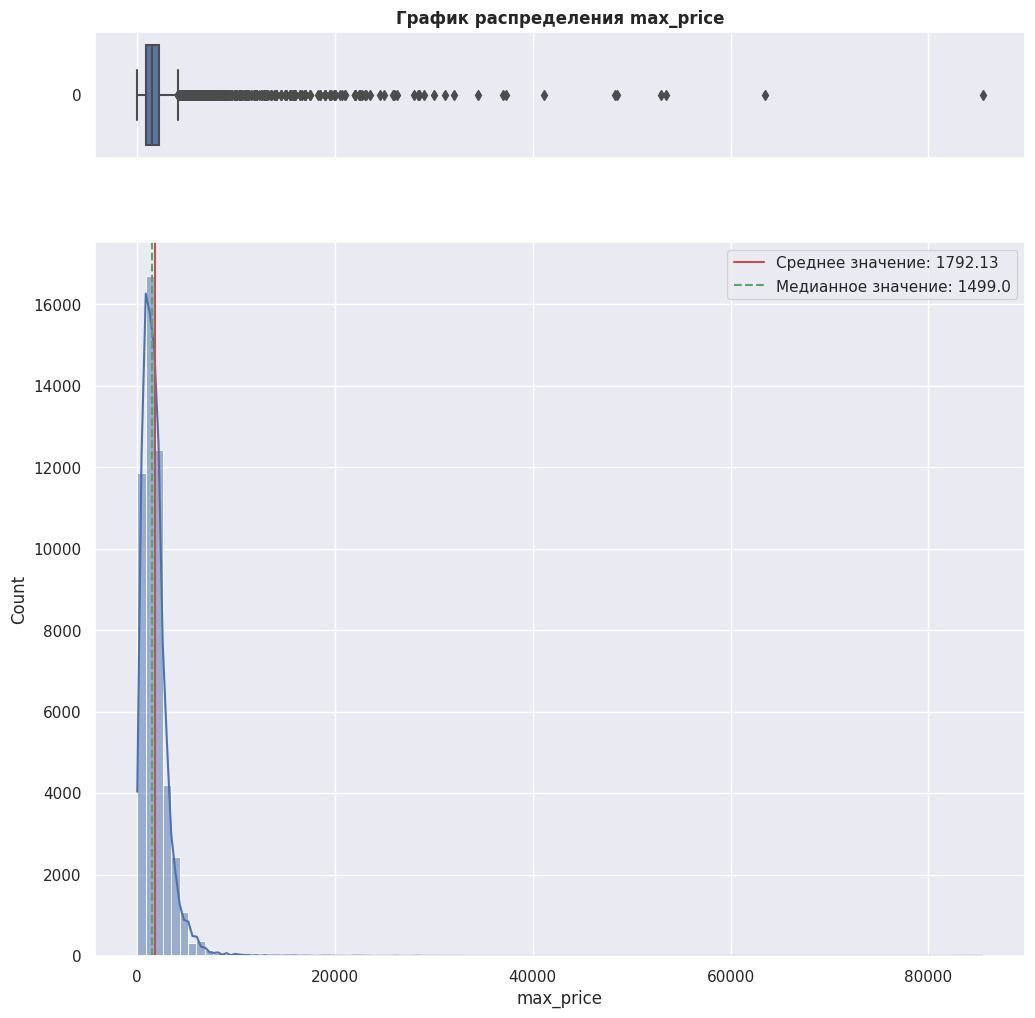

In [30]:
numeric_analysis(df_purchas_price_grouped, 'max_price', 'max_price')

count   49849.00
mean     1238.22
std      1384.68
min         1.00
25%       399.00
50%       999.00
75%      1749.00
max     53499.00
Name: min_price, dtype: float64

Верхний ус: 3774.0 
Нижний ус: -1626.0     
Медианное значение: 999.0


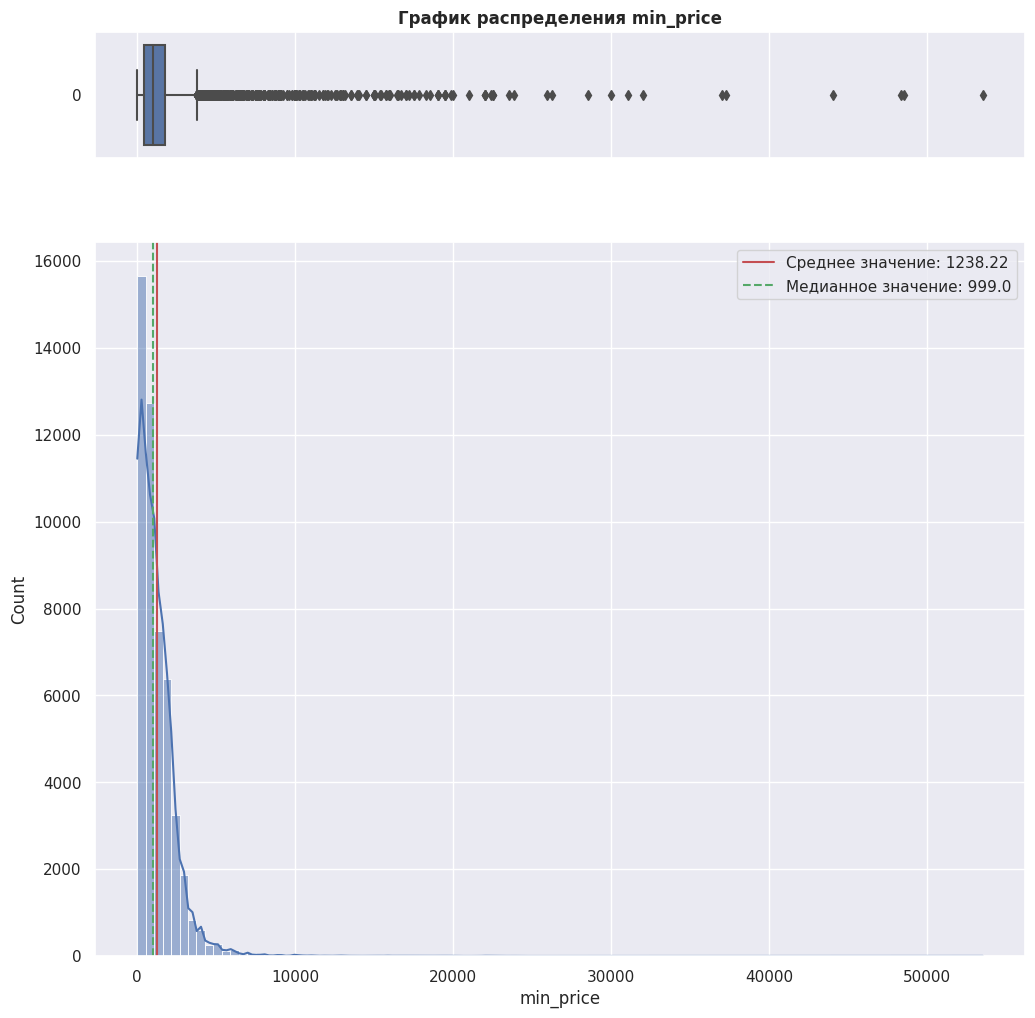

In [31]:
numeric_analysis(df_purchas_price_grouped, 'min_price', 'min_price')

In [32]:
df_purchas_quantity_grouped = df_purchas.groupby('client_id')['quantity'].agg(['min', 'max']).reset_index()
df_purchas_quantity_grouped.rename(columns = {'min': 'min_quantity',
                                           'max': 'max_quantity'}, inplace=True)
df_purchas_quantity_grouped['diff_min_max_quantity'] = df_purchas_quantity_grouped['max_quantity'] - df_purchas_quantity_grouped['min_quantity']


In [33]:
df_purchas_quantity_grouped.head()

,client_id,min_quantity,max_quantity,diff_min_max_quantity
0,1515915625468060902,1,1,0
1,1515915625468061003,1,1,0
2,1515915625468061099,1,1,0
3,1515915625468061100,1,1,0
4,1515915625468061170,1,1,0


In [34]:
df_purchas_pivot_date = pd.pivot_table(df_purchas, values=['quantity' , 'price'], index=['date'], aggfunc="mean").reset_index()
df_purchas_pivot_date.rename(columns={'price': 'mean_price',
                                      'quantity': 'mean_quantity'}, inplace=True)

In [35]:
df_purchas_pivot_date

,date,mean_price,mean_quantity
0,2022-05-16,1729.56,1.06
1,2022-05-17,1740.31,1.01
2,2022-05-18,1811.22,1.02
3,2022-05-19,1352.49,1.01
4,2022-05-20,1727.13,1.02
...,...,...,...
637,2024-02-12,942.70,1.01
638,2024-02-13,1093.84,1.02
639,2024-02-14,1445.55,1.00
640,2024-02-15,998.28,1.01


In [36]:
df_purchas_pivot_date['mean_quantity'].describe()

count   642.00
mean      1.01
std       0.02
min       1.00
25%       1.00
50%       1.00
75%       1.01
max       1.20
Name: mean_quantity, dtype: float64

In [37]:
df_purchas_grouped = df_purchas.groupby('client_id')['category_ids'].sum().reset_index()

In [38]:
df_purchas_grouped

,client_id,category_ids
0,1515915625468060902,"['4', '27', '176', '458']['4', '28', '260', '4..."
1,1515915625468061003,"['4', '28', '249', '615']['4', '28', '249', '6..."
2,1515915625468061099,"['4', '28', '290', '424']"
3,1515915625468061100,"['4', '27', '1828', '5717']['4', '27', '1828',..."
4,1515915625468061170,"[][]['2', '18', '258', '441']['2', '18', '258'..."
...,...,...
49844,1515915626010261344,"['2', '18', '212', '726']['2', '18', '212', '7..."
49845,1515915626010266132,"['4', '27', '278', '470']['4', '27', '278', '4..."
49846,1515915626010439406,"['4', '27', '233', '462']['4', '27', '233', '4..."
49847,1515915626010443527,"['2', '18', '274', '446']"


In [39]:
# Объединение категорий покупок в один список
df_purchas['category_ids'] = df_purchas['category_ids'].apply(ast.literal_eval)

df_purchas_grouped = df_purchas.groupby('client_id')['category_ids'].agg(lambda x: list(chain.from_iterable(x))).reset_index()

In [40]:
df_purchas_grouped.head()

,client_id,category_ids
0,1515915625468060902,"[4, 27, 176, 458, 4, 28, 260, 420, 4, 27, 1828..."
1,1515915625468061003,"[4, 28, 249, 615, 4, 28, 249, 615, 4, 28, 249,..."
2,1515915625468061099,"[4, 28, 290, 424]"
3,1515915625468061100,"[4, 27, 1828, 5717, 4, 27, 1828, 5717]"
4,1515915625468061170,"[2, 18, 258, 441, 2, 18, 258, 441, 4, 28, 260,..."


In [41]:
# Сортируем маркеры категорий в списке
def convert_and_sort(category_list):
    return sorted(filter(lambda y: y is not None, map(lambda x: int(x) if x is not None else None, category_list)))

df_purchas_grouped['category_ids_sorted'] = df_purchas_grouped['category_ids'].apply(convert_and_sort)

In [42]:
# Получаем сумму категорий покупок
df_purchas_grouped['cat_sum'] = df_purchas_grouped['category_ids_sorted'].apply(
    lambda x: sum(int(num) for num in x if num is not None) if isinstance(x, list) else 0
)

In [43]:
df_purchas_grouped.head()

,client_id,category_ids,category_ids_sorted,cat_sum
0,1515915625468060902,"[4, 27, 176, 458, 4, 28, 260, 420, 4, 27, 1828...","[4, 4, 4, 4, 4, 4, 4, 27, 27, 27, 28, 28, 28, ...",7664
1,1515915625468061003,"[4, 28, 249, 615, 4, 28, 249, 615, 4, 28, 249,...","[4, 4, 4, 4, 4, 4, 4, 28, 28, 28, 28, 28, 28, ...",6272
2,1515915625468061099,"[4, 28, 290, 424]","[4, 28, 290, 424]",746
3,1515915625468061100,"[4, 27, 1828, 5717, 4, 27, 1828, 5717]","[4, 4, 27, 27, 1828, 1828, 5717, 5717]",15152
4,1515915625468061170,"[2, 18, 258, 441, 2, 18, 258, 441, 4, 28, 260,...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",12106


In [44]:
# Получаем уникальные элементы категорий
df_purchas_grouped_unique = df_purchas.groupby('client_id')['category_ids'].agg(lambda x: list(dict.fromkeys(chain.from_iterable(x)))).reset_index()

In [45]:
df_purchas_grouped_unique.head()

,client_id,category_ids
0,1515915625468060902,"[4, 27, 176, 458, 28, 260, 420, 1828, 1599, 29..."
1,1515915625468061003,"[4, 28, 249, 615]"
2,1515915625468061099,"[4, 28, 290, 424]"
3,1515915625468061100,"[4, 27, 1828, 5717]"
4,1515915625468061170,"[2, 18, 258, 441, 4, 28, 260, 420, 244, 432]"


In [46]:
df_purchas_grouped = df_purchas_grouped_unique.category_ids.apply(pd.Series) \
    .merge(df_purchas_grouped.drop('category_ids_sorted', axis=1), right_index = True, left_index = True) \
    .drop(["category_ids"], axis = 1)

In [47]:
df_purchas_grouped = df_purchas_grouped.drop(df_purchas_grouped.columns[1:87], axis=1)

In [48]:
df_purchas_grouped.head()

,0,client_id,cat_sum
0,4,1515915625468060902,7664
1,4,1515915625468061003,6272
2,4,1515915625468061099,746
3,4,1515915625468061100,15152
4,2,1515915625468061170,12106


In [49]:
df_purchas_grouped.rename(columns={0: 'cat_1',
                                   1: 'cat_2'}, inplace=True)

In [50]:
df_purchas_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cat_1      49551 non-null  object
 1   client_id  49849 non-null  int64 
 2   cat_sum    49849 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [51]:
df_purchas_grouped['cat_1'].value_counts(dropna=False)

cat_1
4       30269
5562     9644
2        8327
6060      979
5963      332
None      297
NaN         1
Name: count, dtype: int64

In [52]:
df_purchas_date_grouped = df_purchas.groupby('client_id')['date'].agg(['min', 'max']).reset_index()
df_purchas_date_grouped

,client_id,min,max
0,1515915625468060902,2022-05-27,2022-05-27
1,1515915625468061003,2023-01-04,2023-01-04
2,1515915625468061099,2022-05-17,2022-05-17
3,1515915625468061100,2024-02-10,2024-02-10
4,1515915625468061170,2023-03-26,2023-06-17
...,...,...,...
49844,1515915626010261344,2024-02-16,2024-02-16
49845,1515915626010266132,2024-02-14,2024-02-14
49846,1515915626010439406,2024-02-16,2024-02-16
49847,1515915626010443527,2024-02-16,2024-02-16


In [53]:
df_purchas_date_grouped['days_between_min_max'] = df_purchas_date_grouped['max'] - df_purchas_date_grouped['min']

In [54]:
df_purchas_date_grouped['days_between_min_max'].describe()

count                         49849
mean     21 days 03:10:22.014483741
std      76 days 20:13:23.836373667
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%                 0 days 00:00:00
75%                 0 days 00:00:00
max               636 days 00:00:00
Name: days_between_min_max, dtype: object

In [55]:
df_purchas_date_grouped

,client_id,min,max,days_between_min_max
0,1515915625468060902,2022-05-27,2022-05-27,0 days
1,1515915625468061003,2023-01-04,2023-01-04,0 days
2,1515915625468061099,2022-05-17,2022-05-17,0 days
3,1515915625468061100,2024-02-10,2024-02-10,0 days
4,1515915625468061170,2023-03-26,2023-06-17,83 days
...,...,...,...,...
49844,1515915626010261344,2024-02-16,2024-02-16,0 days
49845,1515915626010266132,2024-02-14,2024-02-14,0 days
49846,1515915626010439406,2024-02-16,2024-02-16,0 days
49847,1515915626010443527,2024-02-16,2024-02-16,0 days


In [56]:
# находим кол-во уникальных дат совершения покупок у клиента
df_purchas_c_unique_dates = df_purchas.groupby('client_id')['date'].nunique().reset_index()

In [57]:
df_purchas_c_unique_dates.head()

,client_id,date
0,1515915625468060902,1
1,1515915625468061003,1
2,1515915625468061099,1
3,1515915625468061100,1
4,1515915625468061170,3


In [58]:
df_purchas_c_unique_dates.rename(columns={'date': 'unique_dates'}, inplace=True)
df_purchas_c_unique_dates.head()

,client_id,unique_dates
0,1515915625468060902,1
1,1515915625468061003,1
2,1515915625468061099,1
3,1515915625468061100,1
4,1515915625468061170,3


In [59]:
df_to_use = df_purchas_pivot.merge(df_purchas_date_grouped, on='client_id')

In [60]:
df_to_use.merge(df_purchas_c_unique_dates, on='client_id').head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,unique_dates
0,1515915625468060902,6993.00,7,999.00,48951.00,2022-05-27,2022-05-27,0 days,1
1,1515915625468061003,16235.00,7,2319.29,113645.00,2023-01-04,2023-01-04,0 days,1
2,1515915625468061099,299.00,1,299.00,299.00,2022-05-17,2022-05-17,0 days,1
3,1515915625468061100,2098.00,2,1049.00,4196.00,2024-02-10,2024-02-10,0 days,1
4,1515915625468061170,33601.00,19,1768.47,638419.00,2023-03-26,2023-06-17,83 days,3


In [61]:
df_to_use['days_between_min_max'] = df_to_use['max'] - df_to_use['min']

In [62]:
df_to_use.head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max
0,1515915625468060902,6993.00,7,999.00,48951.00,2022-05-27,2022-05-27,0 days
1,1515915625468061003,16235.00,7,2319.29,113645.00,2023-01-04,2023-01-04,0 days
2,1515915625468061099,299.00,1,299.00,299.00,2022-05-17,2022-05-17,0 days
3,1515915625468061100,2098.00,2,1049.00,4196.00,2024-02-10,2024-02-10,0 days
4,1515915625468061170,33601.00,19,1768.47,638419.00,2023-03-26,2023-06-17,83 days


In [63]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [64]:
df_message_filter = df_messages[df_messages['client_id'].isin(df_purchas['client_id'])].reset_index()

In [65]:
df_message_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950921 entries, 0 to 10950920
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   index             int64         
 1   bulk_campaign_id  int64         
 2   client_id         int64         
 3   message_id        object        
 4   event             object        
 5   channel           object        
 6   date              datetime64[ns]
 7   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 668.4+ MB


In [66]:
# находим уникальные каналы маркетинга
df_channel = df_message_filter.groupby('client_id')['channel'].unique().reset_index()

In [67]:
df_channel.head()

,client_id,channel
0,1515915625468060902,[email]
1,1515915625468061003,[email]
2,1515915625468061099,"[email, mobile_push]"
3,1515915625468061100,[mobile_push]
4,1515915625468061170,"[email, mobile_push]"


In [68]:
# находим все события в отношении клиента
df_event = df_message_filter.groupby('client_id')['event'].agg(list).reset_index()

In [69]:
df_event.head()

,client_id,event
0,1515915625468060902,"[send, send, send, send, open, click, click, p..."
1,1515915625468061003,"[send, send, send, send, send, send, send, sen..."
2,1515915625468061099,"[send, send, send, send, send, send, open, sen..."
3,1515915625468061100,"[send, send, send, send, send, send, send, sen..."
4,1515915625468061170,"[send, send, open, send, open, send, open, cli..."


In [70]:
def_mes = df_message_filter.groupby('client_id')['message_id'].unique().reset_index()

In [71]:
df_event_seq = df_messages.groupby(['client_id','message_id'])['event'].agg(list).reset_index()

In [72]:
df_event_seq['seq_len'] = df_event_seq['event'].apply(len)

In [73]:
df_event_seq[(df_event_seq['seq_len'] > 3) & (df_event_seq['seq_len'] < 10)].sort_values('seq_len', ascending=False).head(10)

,client_id,message_id,event,seq_len
6102250,1515915625566605425,1515915625566605425-11144-641ad2b8970e0,"[send, open, open, click, click, click, click,...",9
4763363,1515915625512189441,1515915625512189441-4492-62873cda27a4b,"[send, open, click, purchase, click, click, pu...",9
2249574,1515915625489140087,1515915625489140087-9341-63c11809d7e17,"[send, open, click, click, click, click, click...",9
3561099,1515915625491155495,1515915625491155495-12650-64673433e7694,"[send, open, click, click, click, open, click,...",9
4767111,1515915625512587751,1515915625512587751-14521-65af8ef8e7181,"[send, open, click, click, click, click, click...",9
7902443,1515915625764142287,1515915625764142287-13842-650945be060b1,"[send, click, open, click, click, click, click...",9
6555646,1515915625581293954,1515915625581293954-5335-62c7d2d474882,"[send, open, click, click, open, click, click,...",9
3879436,1515915625491786227,1515915625491786227-4492-62873cbf5ee93,"[send, open, click, click, open, click, click,...",9
7166519,1515915625628521921,1515915625628521921-13496-64b668a73da8a,"[send, open, click, click, click, click, click...",9
4822589,1515915625520751253,1515915625520751253-4568-628ddb20bde91,"[send, open, click, open, click, click, click,...",9


Если судить по первым двум клиентам в таблице, то воронка коммуникации работает адекватно. Отправили сообщение -> Открыл сообщение -> Действия на сайте -> Покупка.

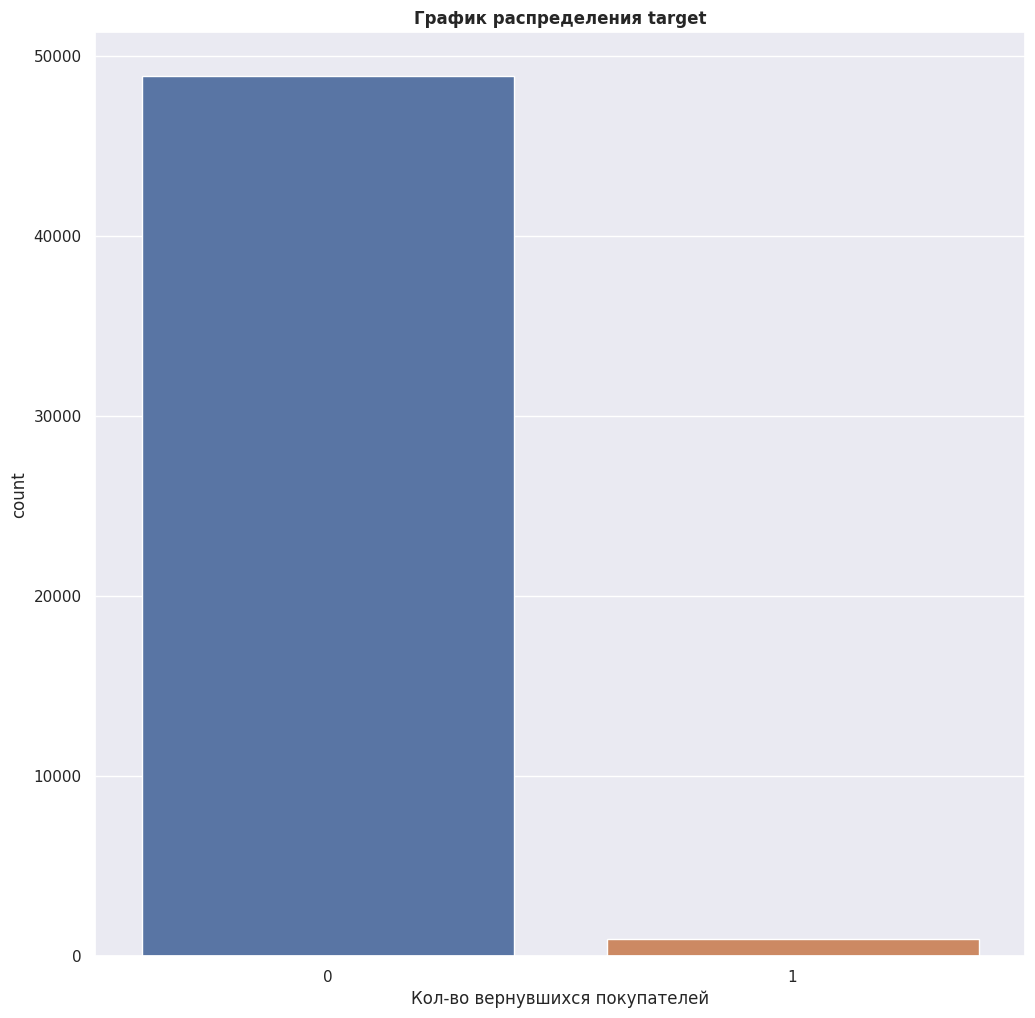

target
0    48888
1      961
Name: count, dtype: int64

In [74]:
cat_vis(df_target, 'target')

Сильный дисбаланс в целевом признаке.

In [75]:
961/48888

0.019657175585010636

## Объединение данных

In [76]:
df_to_use = pd.merge(df_to_use, df_channel, on='client_id', how='outer')

In [77]:
df_to_use = pd.merge(df_to_use, df_event, on='client_id', how='outer')
df_to_use = pd.merge(df_to_use, def_mes, on='client_id', how='outer')

In [78]:
df_to_use = pd.merge(df_to_use, df_purchas_price_grouped, on='client_id', how='outer')

In [79]:
df_to_use = pd.merge(df_to_use, df_purchas_grouped, on='client_id')

In [80]:
df_to_use = pd.merge(df_to_use, df_purchas_quantity_grouped, on='client_id')

In [81]:
df_to_use.head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,channel,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity
0,1515915625468060902,6993.00,7,999.00,48951.00,2022-05-27,2022-05-27,0 days,[email],"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.00,1999.00,1800.00,4,7664,1,1,0
1,1515915625468061003,16235.00,7,2319.29,113645.00,2023-01-04,2023-01-04,0 days,[email],"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.00,3499.00,1750.00,4,6272,1,1,0
2,1515915625468061099,299.00,1,299.00,299.00,2022-05-17,2022-05-17,0 days,"[email, mobile_push]","[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.00,299.00,0.00,4,746,1,1,0
3,1515915625468061100,2098.00,2,1049.00,4196.00,2024-02-10,2024-02-10,0 days,[mobile_push],"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.00,1049.00,0.00,4,15152,1,1,0
4,1515915625468061170,33601.00,19,1768.47,638419.00,2023-03-26,2023-06-17,83 days,"[email, mobile_push]","[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.00,2699.00,2692.00,2,12106,1,1,0


In [82]:
type(df_to_use['event'][0])

list

In [83]:
#переводим признаки в списки для последующей обработки
df_to_use['channel'] = df_to_use['channel'].apply(lambda x: x if isinstance(x, np.ndarray) else [])
df_to_use['event'] = df_to_use['event'].apply(lambda x: x if isinstance(x, list) else [])
df_to_use['event_unique'] = df_to_use['event'].apply(lambda x: np.unique(x) if isinstance(x, list) else [])
df_to_use['message_id'] = df_to_use['message_id'].apply(lambda x: x if isinstance(x, np.ndarray) else [])

In [84]:
df_to_use['event_unique'] = df_to_use['event'].apply(
    lambda x: ' '.join(np.unique(x)) if isinstance(x, list) else ''
)

In [85]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   client_id              49849 non-null  int64          
 1   sum_price              49849 non-null  float64        
 2   sum_quantity           49849 non-null  int64          
 3   mean_price             49849 non-null  float64        
 4   total_price            49849 non-null  float64        
 5   min                    49849 non-null  datetime64[ns] 
 6   max                    49849 non-null  datetime64[ns] 
 7   days_between_min_max   49849 non-null  timedelta64[ns]
 8   channel                49849 non-null  object         
 9   event                  49849 non-null  object         
 10  message_id             49849 non-null  object         
 11  min_price              49849 non-null  float64        
 12  max_price              49849 non-null  float64

In [86]:
def count_size(df, col):
  df[col+'_size'] = df[col].apply(len)
  return df

In [87]:
df_to_use = count_size(df_to_use, 'channel')
df_to_use = count_size(df_to_use, 'event')
df_to_use = count_size(df_to_use, 'message_id')
df_to_use = count_size(df_to_use, 'event_unique')

In [88]:
df_to_use = df_to_use.merge(df_purchas_c_unique_dates, on='client_id')

In [89]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   client_id              49849 non-null  int64          
 1   sum_price              49849 non-null  float64        
 2   sum_quantity           49849 non-null  int64          
 3   mean_price             49849 non-null  float64        
 4   total_price            49849 non-null  float64        
 5   min                    49849 non-null  datetime64[ns] 
 6   max                    49849 non-null  datetime64[ns] 
 7   days_between_min_max   49849 non-null  timedelta64[ns]
 8   channel                49849 non-null  object         
 9   event                  49849 non-null  object         
 10  message_id             49849 non-null  object         
 11  min_price              49849 non-null  float64        
 12  max_price              49849 non-null  float64

In [90]:
df_message_filter['msg_year'] = df_message_filter.date.dt.year

In [91]:
df_message_filter['msg_month'] = df_message_filter.date.dt.month

In [92]:
df_message_filter['msg_day_of_week'] = df_message_filter.date.dt.day_of_week

In [93]:
df_message_filter.head()

,index,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,msg_year,msg_month,msg_day_of_week
0,0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,2022,5,3
1,1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,2022,5,3
2,2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,2022,5,3
3,3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,2022,5,3
4,4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,2022,5,3


In [94]:
df_min_max_date = df_message_filter.groupby('client_id')['date'].agg(['min', 'max']).reset_index()

In [95]:
df_min_max_date['days_between_min_max_msg'] = df_min_max_date['max'] - df_min_max_date['min']

In [96]:
df_min_max_date['min_year_msg'] = df_min_max_date['min'].dt.year
df_min_max_date['max_year_msg'] = df_min_max_date['max'].dt.year
df_min_max_date['min_month_msg'] = df_min_max_date['min'].dt.month
df_min_max_date['max_month_msg'] = df_min_max_date['max'].dt.month
df_min_max_date['min_day_of_week_msg'] = df_min_max_date['min'].dt.day_of_week
df_min_max_date['max_day_of_week_msg'] = df_min_max_date['max'].dt.day_of_week
df_min_max_date['min_day_of_year_msg'] = df_min_max_date['min'].dt.day_of_year
df_min_max_date['max_day_of_year_msg'] = df_min_max_date['max'].dt.day_of_year

In [97]:
df_min_max_date.head()

,client_id,min,max,days_between_min_max_msg,min_year_msg,max_year_msg,min_month_msg,max_month_msg,min_day_of_week_msg,max_day_of_week_msg,min_day_of_year_msg,max_day_of_year_msg
0,1515915625468060902,2022-05-19,2024-01-19,610 days,2022,2024,5,1,3,4,139,19
1,1515915625468061003,2022-05-20,2024-02-13,634 days,2022,2024,5,2,4,1,140,44
2,1515915625468061099,2022-05-19,2024-02-13,635 days,2022,2024,5,2,3,1,139,44
3,1515915625468061100,2022-05-19,2024-02-15,637 days,2022,2024,5,2,3,3,139,46
4,1515915625468061170,2022-05-25,2024-02-15,631 days,2022,2024,5,2,2,3,145,46


In [98]:
df_to_use = pd.merge(df_to_use, df_min_max_date.drop(['min', 'max'], axis=1), on='client_id', how='outer')

In [99]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   client_id                 49849 non-null  int64          
 1   sum_price                 49849 non-null  float64        
 2   sum_quantity              49849 non-null  int64          
 3   mean_price                49849 non-null  float64        
 4   total_price               49849 non-null  float64        
 5   min                       49849 non-null  datetime64[ns] 
 6   max                       49849 non-null  datetime64[ns] 
 7   days_between_min_max      49849 non-null  timedelta64[ns]
 8   channel                   49849 non-null  object         
 9   event                     49849 non-null  object         
 10  message_id                49849 non-null  object         
 11  min_price                 49849 non-null  float64        
 12  max_

In [100]:
df_to_use['min_year_purchas'] = df_to_use['min'].dt.year
df_to_use['max_year_purchas'] = df_to_use['max'].dt.year
df_to_use['min_month_purchas'] = df_to_use['min'].dt.month
df_to_use['max_month_purchas'] = df_to_use['max'].dt.month
df_to_use['min_day_of_week_purchas'] = df_to_use['min'].dt.day_of_week
df_to_use['max_day_of_week_purchas'] = df_to_use['max'].dt.day_of_week
df_to_use['min_day_of_year_purchas'] = df_to_use['min'].dt.day_of_year
df_to_use['max_day_of_year_purchas'] = df_to_use['max'].dt.day_of_year

In [101]:
df_to_use = pd.merge(df_to_use, df_target, on='client_id')

In [102]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   client_id                 49849 non-null  int64          
 1   sum_price                 49849 non-null  float64        
 2   sum_quantity              49849 non-null  int64          
 3   mean_price                49849 non-null  float64        
 4   total_price               49849 non-null  float64        
 5   min                       49849 non-null  datetime64[ns] 
 6   max                       49849 non-null  datetime64[ns] 
 7   days_between_min_max      49849 non-null  timedelta64[ns]
 8   channel                   49849 non-null  object         
 9   event                     49849 non-null  object         
 10  message_id                49849 non-null  object         
 11  min_price                 49849 non-null  float64        
 12  max_

In [103]:
df_to_use['days_between_min_max'] = df_to_use['days_between_min_max'].dt.days
df_to_use['days_between_min_max_msg'] = df_to_use['days_between_min_max_msg'].dt.days

In [104]:
df_to_use = df_to_use.channel.apply(pd.Series) \
    .merge(df_to_use, right_index = True, left_index = True) \
    .drop(["channel"], axis = 1)

In [105]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   0                         41982 non-null  object        
 1   1                         20272 non-null  object        
 2   client_id                 49849 non-null  int64         
 3   sum_price                 49849 non-null  float64       
 4   sum_quantity              49849 non-null  int64         
 5   mean_price                49849 non-null  float64       
 6   total_price               49849 non-null  float64       
 7   min                       49849 non-null  datetime64[ns]
 8   max                       49849 non-null  datetime64[ns]
 9   days_between_min_max      49849 non-null  int64         
 10  event                     49849 non-null  object        
 11  message_id                49849 non-null  object        
 12  min_price         

In [106]:
df_to_use.rename(columns = {0: 'channel_1',
                            1: 'channel_2'}, inplace=True)

In [107]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   channel_1                 41982 non-null  object        
 1   channel_2                 20272 non-null  object        
 2   client_id                 49849 non-null  int64         
 3   sum_price                 49849 non-null  float64       
 4   sum_quantity              49849 non-null  int64         
 5   mean_price                49849 non-null  float64       
 6   total_price               49849 non-null  float64       
 7   min                       49849 non-null  datetime64[ns]
 8   max                       49849 non-null  datetime64[ns]
 9   days_between_min_max      49849 non-null  int64         
 10  event                     49849 non-null  object        
 11  message_id                49849 non-null  object        
 12  min_price         

In [108]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   channel_1                 41982 non-null  object        
 1   channel_2                 20272 non-null  object        
 2   client_id                 49849 non-null  int64         
 3   sum_price                 49849 non-null  float64       
 4   sum_quantity              49849 non-null  int64         
 5   mean_price                49849 non-null  float64       
 6   total_price               49849 non-null  float64       
 7   min                       49849 non-null  datetime64[ns]
 8   max                       49849 non-null  datetime64[ns]
 9   days_between_min_max      49849 non-null  int64         
 10  event                     49849 non-null  object        
 11  message_id                49849 non-null  object        
 12  min_price         

In [109]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   channel_1                 41982 non-null  object        
 1   channel_2                 20272 non-null  object        
 2   client_id                 49849 non-null  int64         
 3   sum_price                 49849 non-null  float64       
 4   sum_quantity              49849 non-null  int64         
 5   mean_price                49849 non-null  float64       
 6   total_price               49849 non-null  float64       
 7   min                       49849 non-null  datetime64[ns]
 8   max                       49849 non-null  datetime64[ns]
 9   days_between_min_max      49849 non-null  int64         
 10  event                     49849 non-null  object        
 11  message_id                49849 non-null  object        
 12  min_price         

In [110]:
df_messages.event.value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

In [111]:
df_to_use['purchase_count'] = df_to_use['event'].apply(lambda x: x.count('purchase'))
df_to_use['unsubscribe_count'] = df_to_use['event'].apply(lambda x: x.count('unsubscribe'))
df_to_use['subscribe_count'] = df_to_use['event'].apply(lambda x: x.count('subscribe'))
df_to_use['complain_count'] = df_to_use['event'].apply(lambda x: x.count('complain'))

In [112]:
df_to_use.drop(columns=['message_id', 'min', 'max'], axis=1, inplace=True)

In [113]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   channel_1                 41982 non-null  object 
 1   channel_2                 20272 non-null  object 
 2   client_id                 49849 non-null  int64  
 3   sum_price                 49849 non-null  float64
 4   sum_quantity              49849 non-null  int64  
 5   mean_price                49849 non-null  float64
 6   total_price               49849 non-null  float64
 7   days_between_min_max      49849 non-null  int64  
 8   event                     49849 non-null  object 
 9   min_price                 49849 non-null  float64
 10  max_price                 49849 non-null  float64
 11  diff_min_max_price        49849 non-null  float64
 12  cat_1                     49551 non-null  object 
 13  cat_sum                   49849 non-null  int64  
 14  min_qu

In [114]:
cat_cols = df_to_use.select_dtypes('object').columns.tolist()
for col in cat_cols:
  df_to_use[col].fillna('uknown', inplace=True)

## Корреляционный анализ

In [115]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   channel_1                 49849 non-null  object 
 1   channel_2                 49849 non-null  object 
 2   client_id                 49849 non-null  int64  
 3   sum_price                 49849 non-null  float64
 4   sum_quantity              49849 non-null  int64  
 5   mean_price                49849 non-null  float64
 6   total_price               49849 non-null  float64
 7   days_between_min_max      49849 non-null  int64  
 8   event                     49849 non-null  object 
 9   min_price                 49849 non-null  float64
 10  max_price                 49849 non-null  float64
 11  diff_min_max_price        49849 non-null  float64
 12  cat_1                     49849 non-null  object 
 13  cat_sum                   49849 non-null  int64  
 14  min_qu

In [116]:
num_cols = df_to_use.drop('client_id', axis=1).select_dtypes(include='number').columns.tolist()
num_cols

['sum_price',
 'sum_quantity',
 'mean_price',
 'total_price',
 'days_between_min_max',
 'min_price',
 'max_price',
 'diff_min_max_price',
 'cat_sum',
 'min_quantity',
 'max_quantity',
 'diff_min_max_quantity',
 'channel_size',
 'event_size',
 'message_id_size',
 'event_unique_size',
 'unique_dates',
 'days_between_min_max_msg',
 'min_year_msg',
 'max_year_msg',
 'min_month_msg',
 'max_month_msg',
 'min_day_of_week_msg',
 'max_day_of_week_msg',
 'min_day_of_year_msg',
 'max_day_of_year_msg',
 'min_year_purchas',
 'max_year_purchas',
 'min_month_purchas',
 'max_month_purchas',
 'min_day_of_week_purchas',
 'max_day_of_week_purchas',
 'min_day_of_year_purchas',
 'max_day_of_year_purchas',
 'target',
 'purchase_count',
 'unsubscribe_count',
 'subscribe_count',
 'complain_count']

In [117]:
corr = df_to_use.drop(columns=['client_id', 'event', 'event_unique']).phik_matrix(interval_cols=num_cols)

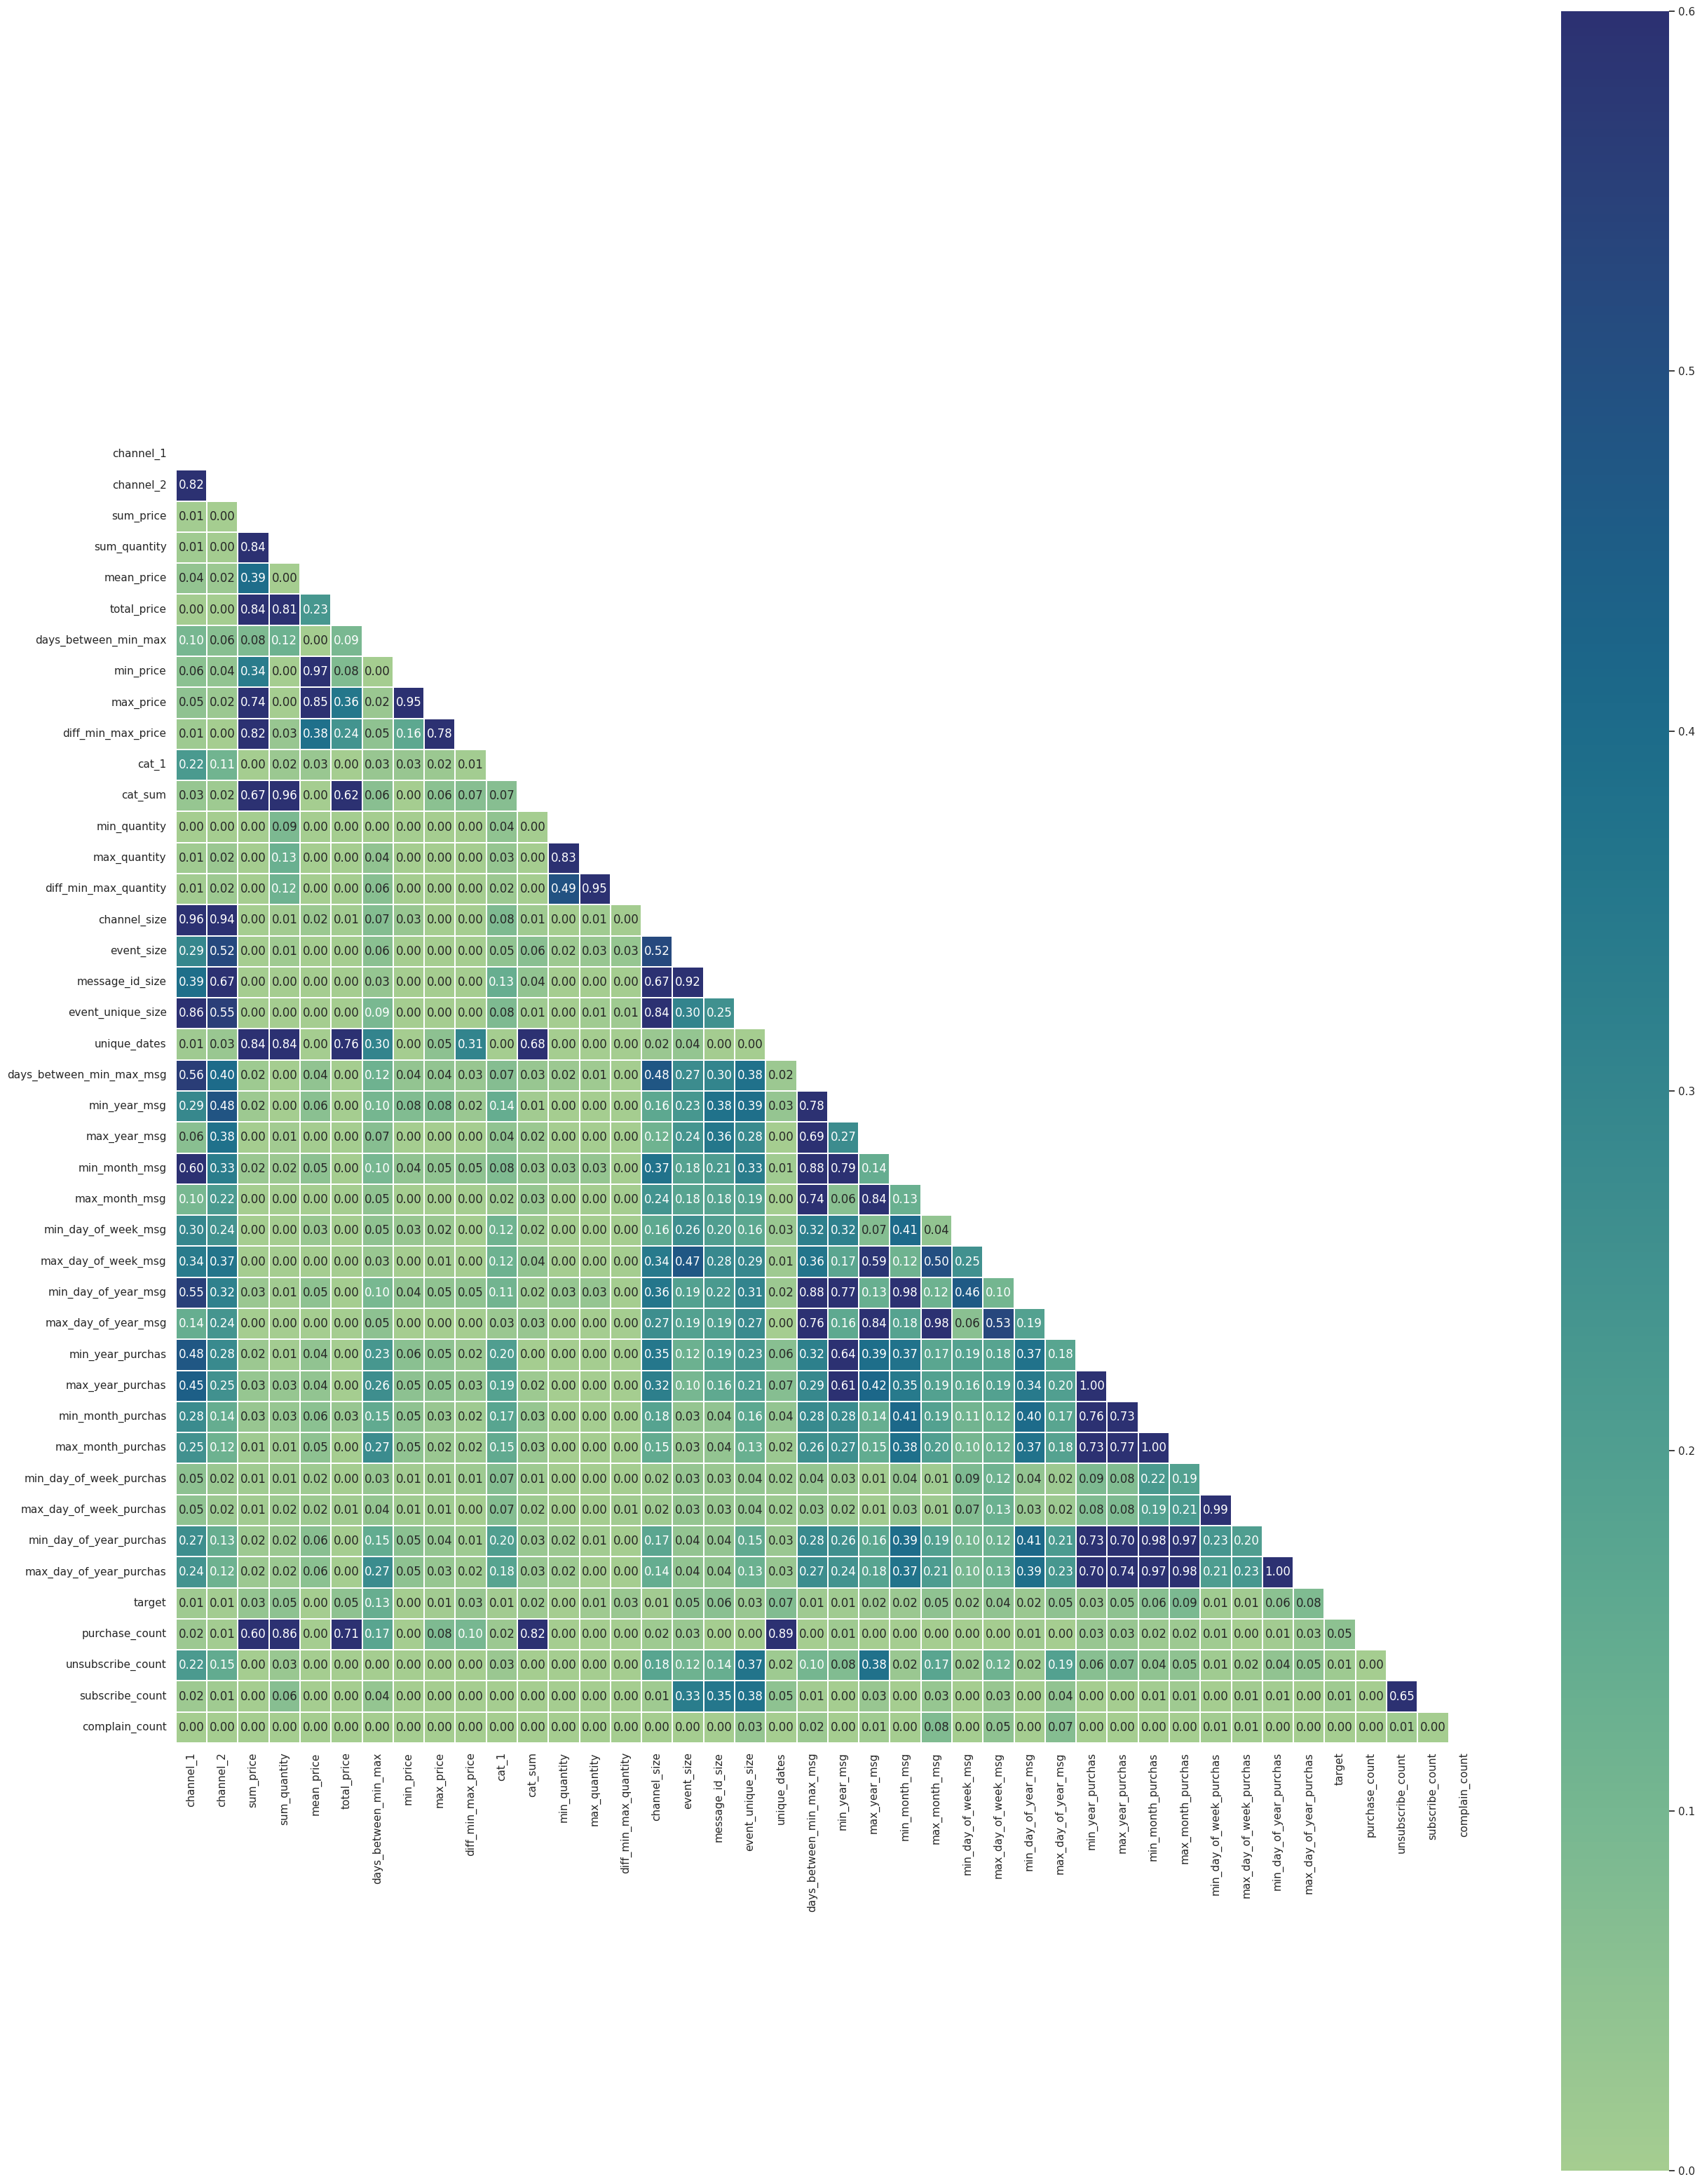

In [118]:
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_theme(style="white")
plt.figure(figsize=(30, 40))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(corr, mask=mask,
            square=True,
            linewidths=.3,
            vmax=0.6,
            annot=True,
            cmap=cmap,
            fmt='.2f')

plt.show()

## Обучение модели и предсказания

In [119]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [120]:
df_to_use = optimize_memory_usage(df_to_use)

Размер использования памяти: до 15.59 Mb - после  6.80 Mb (56.4%)


In [121]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   channel_1                 49849 non-null  object 
 1   channel_2                 49849 non-null  object 
 2   client_id                 49849 non-null  int64  
 3   sum_price                 49849 non-null  float32
 4   sum_quantity              49849 non-null  int16  
 5   mean_price                49849 non-null  float32
 6   total_price               49849 non-null  float32
 7   days_between_min_max      49849 non-null  int16  
 8   event                     49849 non-null  object 
 9   min_price                 49849 non-null  float32
 10  max_price                 49849 non-null  float32
 11  diff_min_max_price        49849 non-null  float32
 12  cat_1                     49849 non-null  object 
 13  cat_sum                   49849 non-null  int32  
 14  min_qu

In [122]:
cols_to_drop = ['client_id', 'target', 'event']

In [123]:
X = df_to_use.drop(columns=cols_to_drop, axis=1)
Y = df_to_use.target

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=Y
)

In [125]:
cat_cols = X_train.drop('event_unique', axis=1).select_dtypes(exclude='number').columns.tolist()
num_cols = X_train.select_dtypes(include='number').columns.tolist()

### KNeighborsClassifier

class ShapeDebugger(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        print(f"Shape: {X.shape} | Type: {type(X)}")
        return X

In [126]:
ohe_pipe = Pipeline(
    [
        (
            'Simple_imputer', 
            SimpleImputer(fill_value='unknown', strategy='constant', copy=False)
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )   
    ]
) 

In [127]:
list_pipe = Pipeline([
    ('col_extractor', FunctionTransformer(lambda x: x.squeeze(),
                                          feature_names_out=lambda self, input_features: input_features,
                                          validate=False)),
    ('cv', CountVectorizer(binary=True))
])

In [128]:
num_pipe = Pipeline(
    [        
        ('KNNImputer', KNNImputer(n_neighbors=5, weights='distance')),
        ('Scaler', StandardScaler())
    ]
)

In [129]:
preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_cols),
        ('num', num_pipe, num_cols),
        ('list', list_pipe, ['event_unique'])
    ], 
    remainder='passthrough'
) 

In [130]:
knn_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_jobs=-1))
    ]
)

In [131]:
knn_param_grid = [
    {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance'],
        'preprocessor__num__Scaler': [MinMaxScaler(), RobustScaler()]
    }
]

In [132]:
knn_rndcv = RandomizedSearchCV(
    estimator=knn_pipe,
    param_distributions=knn_param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

In [133]:
knn_rndcv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('Simple_imputer',
                                                                                                SimpleImputer(copy=False,
                                                                                                              fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['channel_1',
                                                                                'channel_2',
                                                                                'cat_1']),
                                                                              ('...
                                                                                                FunctionTransformer(feature_names_out=<function <lambda> at 0x7da5ba006f20>,
                                                                                                                    func=<function <lambda> at 0x7da5ba006ca0>)),
                                                                                               ('cv',
                                                                                                CountVectorizer(binary=True))]),
                                                                               ['event_unique'])])),
                                             ('model',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_jobs=-1,
                   param_distributions=[{'model__n_neighbors': [3, 5, 7],
                                         'model__weights': ['uniform',
                                                            'distance'],
                                         'preprocessor__num__Scaler': [MinMaxScaler(),
                                                                       RobustScaler()]}],
                   random_state=15, scoring='roc_auc')

In [134]:
pd.DataFrame(knn_rndcv.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__Scaler,param_model__weights,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,65.81,8.89,16.89,4.98,MinMaxScaler(),distance,7,"{'preprocessor__num__Scaler': MinMaxScaler(), ...",0.58,0.56,0.58,0.57,0.57,0.57,0.01,1
1,65.98,5.44,19.14,2.16,MinMaxScaler(),distance,5,"{'preprocessor__num__Scaler': MinMaxScaler(), ...",0.57,0.54,0.57,0.55,0.57,0.56,0.01,2
6,67.07,8.15,18.01,2.38,MinMaxScaler(),uniform,5,"{'preprocessor__num__Scaler': MinMaxScaler(), ...",0.57,0.54,0.57,0.55,0.57,0.56,0.02,3
0,68.71,9.45,19.33,1.73,RobustScaler(),distance,7,"{'preprocessor__num__Scaler': RobustScaler(), ...",0.58,0.54,0.56,0.54,0.54,0.55,0.02,4
4,68.26,8.56,19.99,3.17,RobustScaler(),uniform,7,"{'preprocessor__num__Scaler': RobustScaler(), ...",0.58,0.54,0.56,0.54,0.54,0.55,0.02,5


### RandomForestClassifier

In [135]:
rf_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_cols),
        ('num', num_pipe, num_cols),
        ('list', list_pipe, ['event_unique'])
    ], 
    remainder='passthrough'
) 

In [136]:
rf_pipe = Pipeline(
    [
        ('preprocessor', rf_preprocessor),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ]
)

In [137]:
rf_param_grid = [
    {
        'model__n_estimators': range(2, 256, 36),
        'model__max_depth': range(2, 16, 4),
        'model__min_samples_split': range(5, 20, 5),
        'model__min_samples_leaf': range(5, 20, 5),
        'model__criterion': ['gini', 'entropy'],
        'preprocessor__num__Scaler': ['passthrough']
    }
]

In [138]:
rf_rndscv = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,
    random_state=RANDOM_STATE)

In [139]:
rf_rndscv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('Simple_imputer',
                                                                                                SimpleImputer(copy=False,
                                                                                                              fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['channel_1',
                                                                                'channel_2',
                                                                                'cat_1']),
                                                                              ('...
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=15))]),
                   n_jobs=-1,
                   param_distributions=[{'model__criterion': ['gini',
                                                              'entropy'],
                                         'model__max_depth': range(2, 16, 4),
                                         'model__min_samples_leaf': range(5, 20, 5),
                                         'model__min_samples_split': range(5, 20, 5),
                                         'model__n_estimators': range(2, 256, 36),
                                         'preprocessor__num__Scaler': ['passthrough']}],
                   random_state=15, scoring='roc_auc')

In [140]:
pd.DataFrame(rf_rndscv.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__Scaler,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_depth,param_model__criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,48.16,0.44,22.07,0.83,passthrough,254,15,10,6,entropy,"{'preprocessor__num__Scaler': 'passthrough', '...",0.71,0.74,0.72,0.72,0.01,1
1,45.49,1.43,26.20,0.32,passthrough,146,5,10,6,entropy,"{'preprocessor__num__Scaler': 'passthrough', '...",0.71,0.74,0.72,0.72,0.01,2
3,50.20,1.34,22.92,0.58,passthrough,254,5,10,6,gini,"{'preprocessor__num__Scaler': 'passthrough', '...",0.70,0.73,0.73,0.72,0.01,3
2,50.21,0.87,22.86,1.27,passthrough,182,5,10,14,gini,"{'preprocessor__num__Scaler': 'passthrough', '...",0.70,0.72,0.72,0.71,0.01,4
0,53.88,0.75,22.67,0.89,passthrough,218,5,5,14,gini,"{'preprocessor__num__Scaler': 'passthrough', '...",0.70,0.72,0.71,0.71,0.01,5


In [141]:
f_importance = rf_rndscv.best_estimator_.named_steps['model'].feature_importances_
f_names = rf_rndscv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

rf_feature_importance_df = pd.DataFrame({
    'Feature': f_names,
    'Importance': f_importance
}).sort_values(by='Importance', ascending=False)

In [142]:
rf_feature_importance_df.head(10)

,Feature,Importance
13,num__days_between_min_max,0.12
25,num__unique_dates,0.08
22,num__event_size,0.06
36,num__max_year_purchas,0.06
42,num__max_day_of_year_purchas,0.05
10,num__sum_quantity,0.05
14,num__min_price,0.05
41,num__min_day_of_year_purchas,0.04
17,num__cat_sum,0.03
12,num__total_price,0.03


### CatBoostClassifier

In [143]:
cbc_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_cols),
        ('num', num_pipe, num_cols),
        ('list', list_pipe, ['event_unique'])
    ], 
    remainder='passthrough'
) 

In [144]:
if get_gpu_device_count() > 0:
    cbc_pipe = Pipeline(
        [
            ('preprocessor', cbc_preprocessor),
            ('models', CatBoostClassifier(random_seed=RANDOM_STATE, logging_level='Silent', task_type='GPU'))
        ]
    )
else:
    cbc_pipe = Pipeline(
        [
            ('preprocessor', cbc_preprocessor),
            ('models', CatBoostClassifier(random_seed=RANDOM_STATE, logging_level='Silent', task_type='CPU'))
        ]
    )

In [145]:
cbc_param_grid = [
     {
        'models__iterations': [1000, 1500, 2000],
        'models__learning_rate': [0.01, 0.1, 0.3, 0.5],
        'models__depth': range(2, 8, 2),
        'models__random_strength': [1, 2, 3],
        'models__l2_leaf_reg': [1, 3, 5],
        'preprocessor__num__Scaler': ['passthrough']
    }
]

In [146]:
cbc_rndscv = RandomizedSearchCV(
    estimator=cbc_pipe,
    param_distributions=cbc_param_grid,
    scoring='roc_auc',
    n_jobs=1,
    cv=3,
    random_state=RANDOM_STATE)

In [147]:
cbc_rndscv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('Simple_imputer',
                                                                                                SimpleImputer(copy=False,
                                                                                                              fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['channel_1',
                                                                                'channel_2',
                                                                                'cat_1']),
                                                                              ('...
                                             ('models',
                                              <catboost.core.CatBoostClassifier object at 0x7da5ba2a4210>)]),
                   n_jobs=1,
                   param_distributions=[{'models__depth': range(2, 8, 2),
                                         'models__iterations': [1000, 1500,
                                                                2000],
                                         'models__l2_leaf_reg': [1, 3, 5],
                                         'models__learning_rate': [0.01, 0.1,
                                                                   0.3, 0.5],
                                         'models__random_strength': [1, 2, 3],
                                         'preprocessor__num__Scaler': ['passthrough']}],
                   random_state=15, scoring='roc_auc')

In [148]:
pd.DataFrame(cbc_rndscv.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__Scaler,param_models__random_strength,param_models__learning_rate,param_models__l2_leaf_reg,param_models__iterations,param_models__depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,60.98,0.10,13.01,0.10,passthrough,3,0.01,5,2000,2,"{'preprocessor__num__Scaler': 'passthrough', '...",0.73,0.74,0.74,0.74,0.01,1
5,43.07,0.13,12.97,0.09,passthrough,1,0.30,3,1000,2,"{'preprocessor__num__Scaler': 'passthrough', '...",0.70,0.71,0.68,0.70,0.01,2
1,52.25,0.14,13.00,0.09,passthrough,3,0.30,1,1500,2,"{'preprocessor__num__Scaler': 'passthrough', '...",0.68,0.70,0.68,0.68,0.01,3
8,64.23,0.34,12.93,0.10,passthrough,2,0.10,1,2000,4,"{'preprocessor__num__Scaler': 'passthrough', '...",0.67,0.67,0.65,0.67,0.01,4
7,70.97,0.43,13.01,0.11,passthrough,3,0.10,1,1500,6,"{'preprocessor__num__Scaler': 'passthrough', '...",0.65,0.64,0.62,0.64,0.01,5


In [149]:
f_importance = cbc_rndscv.best_estimator_.named_steps['models'].feature_importances_
f_names = cbc_rndscv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

cbc_feature_importance_df = pd.DataFrame({
    'Feature': f_names,
    'Importance': f_importance
}).sort_values(by='Importance', ascending=False)

In [150]:
cbc_feature_importance_df.head(10)

,Feature,Importance
13,num__days_between_min_max,17.36
36,num__max_year_purchas,12.76
22,num__event_size,10.68
14,num__min_price,10.24
25,num__unique_dates,4.90
38,num__max_month_purchas,4.61
30,num__max_month_msg,3.55
34,num__max_day_of_year_msg,3.14
11,num__mean_price,2.93
42,num__max_day_of_year_purchas,2.40


In [153]:
print(f"KNeighborsClassifier: {sorted(knn_rndcv.cv_results_['mean_test_score'], reverse=True)[0]}\n"
      f"RandomForestClassifier: {sorted(rf_rndscv.cv_results_['mean_test_score'], reverse=True)[0]}\n"
      f"CatBoostClassifier: {sorted(cbc_rndscv.cv_results_['mean_test_score'], reverse=True)[0]}" 
     )

KNeighborsClassifier: 0.5717762980866946
RandomForestClassifier: 0.7231175515067664
CatBoostClassifier: 0.7351616740289876


In [154]:
best_model = cbc_rndscv.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

In [155]:
roc_auc_score(y_test, y_proba)

0.7117258447189724

In [156]:
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=15, strategy='stratified')

In [157]:
dummy_y = dummy_model.predict(X_test)
dummy_pred_y = dummy_model.predict_proba(X_test)[:, 1]

In [158]:
f1_dummy = f1_score(y_test, dummy_y)
roc_auc_dummy = roc_auc_score(y_test, dummy_pred_y)
pd.DataFrame(data=[f1_dummy, roc_auc_dummy], index=['f1_dummy', 'roc_auc_dummy'], columns=['score'])

,score
f1_dummy,0.03
roc_auc_dummy,0.50


Модель прошла тест на адеватность.

In [159]:
X_test_preprocessed = best_model.named_steps['preprocessor'].transform(X_test)

In [160]:
explainer = shap.TreeExplainer(best_model.named_steps['models'])
shap_values = explainer(X_test_preprocessed)

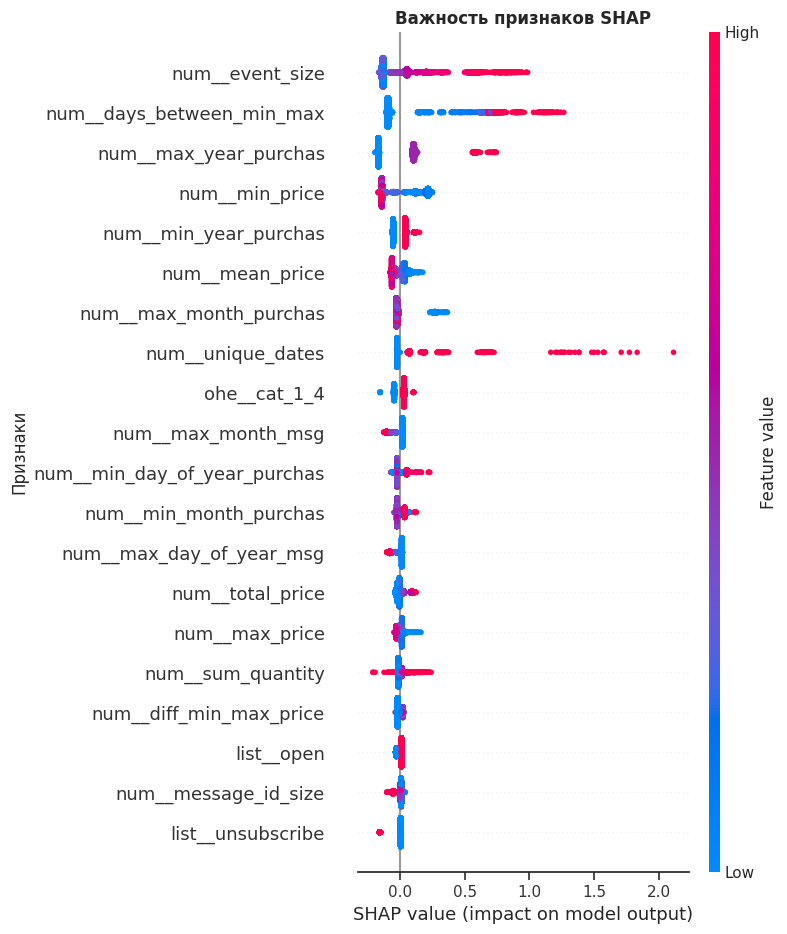

In [162]:
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=f_names, show=False)

plt.title("Важность признаков SHAP", weight='bold')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

* Модель считает, что чем больше событий произошло после матркетинговой акции, тем выше шанс покупки.
* Чем больше дней прошло между покупками, тем выше шанс, что будет покупка. Нужно проанализировать через какой срок оптимальнее всего отправлять маркетинговые сообщения.
* Год последней покупки также важен. Отчасти это коррелирует с кол-вом дней прошедших между покупками.
* Цены на товары также влияют на вероятность покупки. Нужно проанализировать категорию товаров, которые просматривал покупатель или оставил в закладках и предложить скидки по ним.
* В 10-ке признаков находится месяц покупки. Причем чем меньше значение, тем выше шанс покупки. 

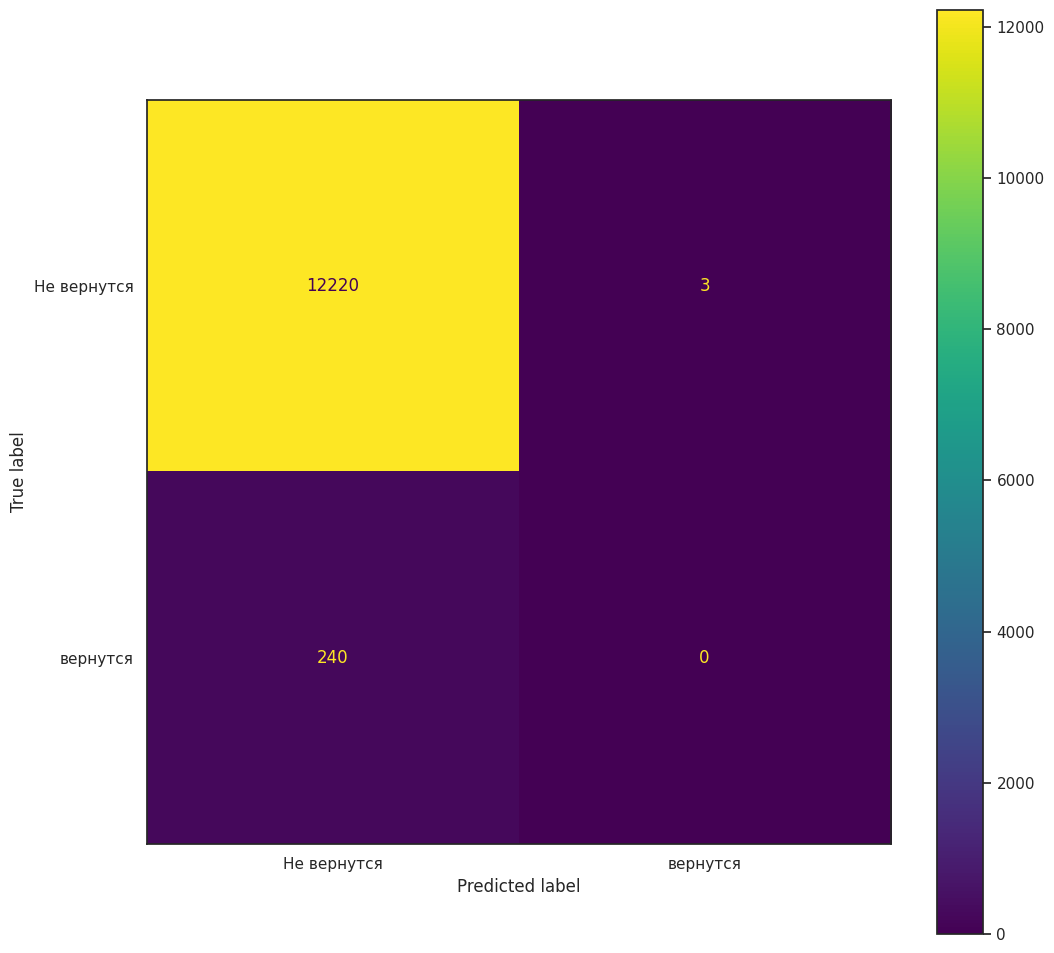

In [170]:
sns.set_theme(style="white")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Не вернутся', 'вернутся'])
disp.plot()

plt.show()

* При текущей разбивке данных модель считает, что ни один покупатель не вернется.
* Модель ошибочно считает, что 240 покупателей не вернется.
* 3 покупатля модель ошибочно отнесла к тем, кто вернется.
* Можно попробовать понизить порог классификации.

In [174]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n'
      f'Recall: {recall_score(y_test, y_pred)}\n'
      f'Precision: {precision_score(y_test, y_pred)}\n'
      f'F1_score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9805022867688358
Recall: 0.0
Precision: 0.0
F1_score: 0.0


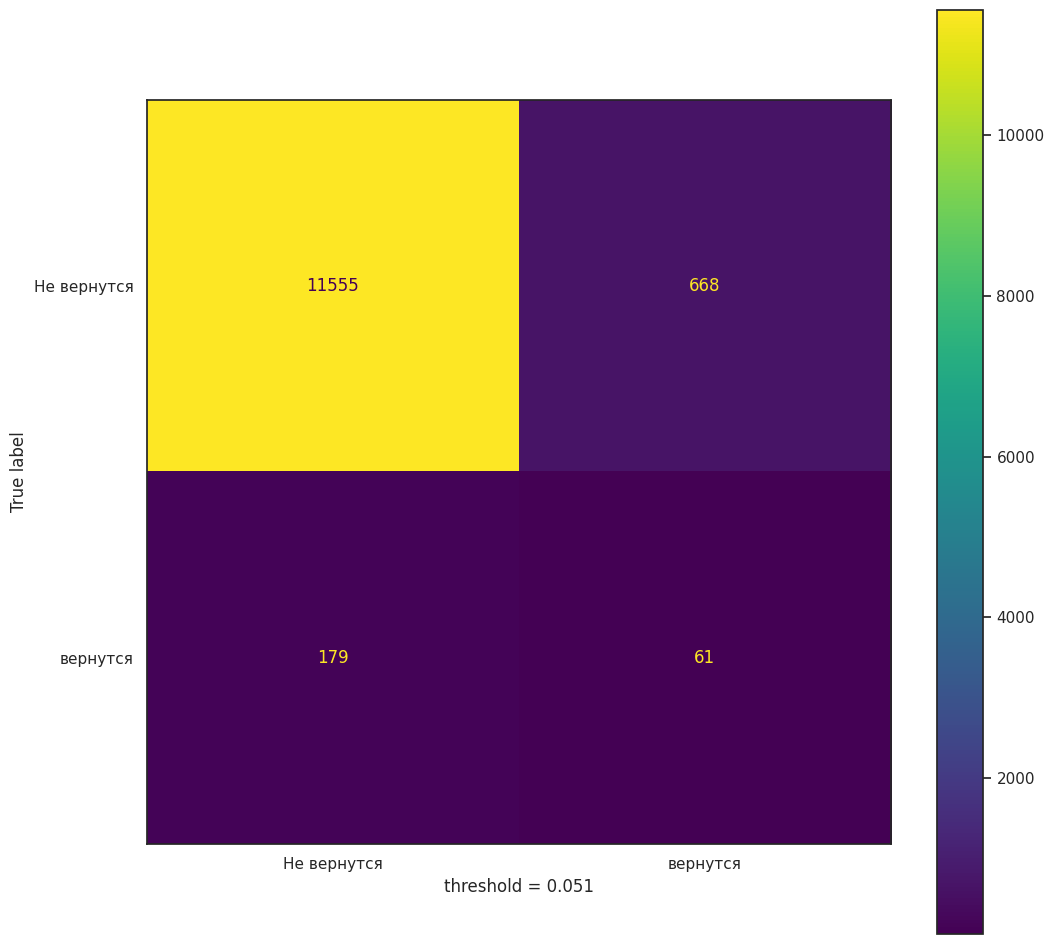

In [194]:
thresholds = np.linspace(0, 1, 100)  # 100 порогов от 0 до 1
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_custom = (y_proba >= best_threshold).astype(int)

cm_custom = confusion_matrix(y_test, y_pred_custom)
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=['Не вернутся', 'вернутся'])
disp.plot()
plt.xlabel(f'threshold = {round(best_threshold, 3)}')
plt.show()

* С подобранным оптимальным порогом по f1, модель определила, что 61 покупатель вернется.
* При этом ложноотрицательных объектов стало больше - 668.
* Для финального решения нужно консультироваться с бизнесом.

In [195]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_custom)}\n'
      f'Recall: {recall_score(y_test, y_pred_custom)}\n'
      f'Precision: {precision_score(y_test, y_pred_custom)}\n'
      f'F1_score: {f1_score(y_test, y_pred_custom)}')

Accuracy: 0.9320388349514563
Recall: 0.25416666666666665
Precision: 0.08367626886145405
F1_score: 0.12590299277605776


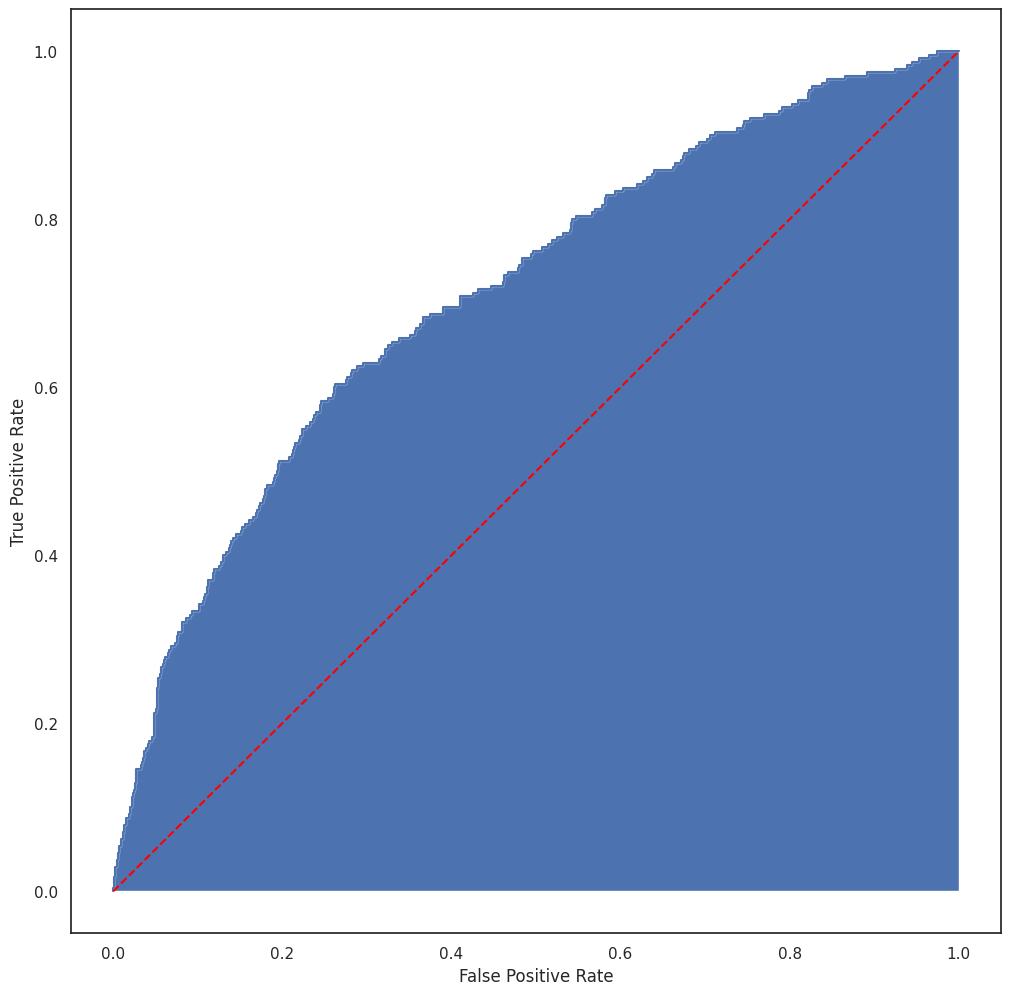

AUC: 0.712


In [196]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

auc = roc_auc_score(y_test, y_proba)
plt.fill_between(fpr, tpr)
plt.show()
print("AUC: %.3f" % auc)

## Вывод

In [199]:
cbc_rndscv.best_params_

{'preprocessor__num__Scaler': 'passthrough',
 'models__random_strength': 3,
 'models__learning_rate': 0.01,
 'models__l2_leaf_reg': 5,
 'models__iterations': 2000,
 'models__depth': 2}

В рамках настоящего проекта необходимо было разработать модель для предсказания покупателей, которые могут вернутся.

Были выполнены следующие этапы:

1. Загрузка библиотек.
2. Загрузка данных.
3. Определение функций.
4. Исследовательский анализ.
5. Подготовка данных.
6. Обучение модели KNN.
7. Обучение модели Случайный лес.
8. Обучение модели CatBoostClassifier
9. Тестирование лучшей модели.

Лучше всего показала себя **CatBoostClassifier** со следущими параметрами.

**ROC_AUC_SCORE** тестовые данные: 0.712


 | Параметры модели   | Значение       |
|--------------------|----------------|
| random_strength | 3            |
| learning_rate | 0.01              |
| l2_leaf_reg     | 5            |
| iterations     | 2000            |
| depth        | 2 |

**Важность признаков:**

* Модель считает, что чем больше событий произошло после матркетинговой акции, тем выше шанс покупки.
* Чем больше дней прошло между покупками, тем выше шанс, что будет покупка. Нужно проанализировать через какой срок оптимальнее всего отправлять маркетинговые сообщения.
* Год последней покупки также важен. Отчасти это коррелирует с кол-вом дней прошедших между покупками.
* Цены на товары также влияют на вероятность покупки. Нужно проанализировать категорию товаров, которые просматривал покупатель или оставил в закладках и предложить скидки по ним.
* Видно, что на модель сильно влияют года, месяцы, дни когда были совершены покупки. Нужно отслеживать праздники, важные даты покупателей для проведения рекламных компаний. 

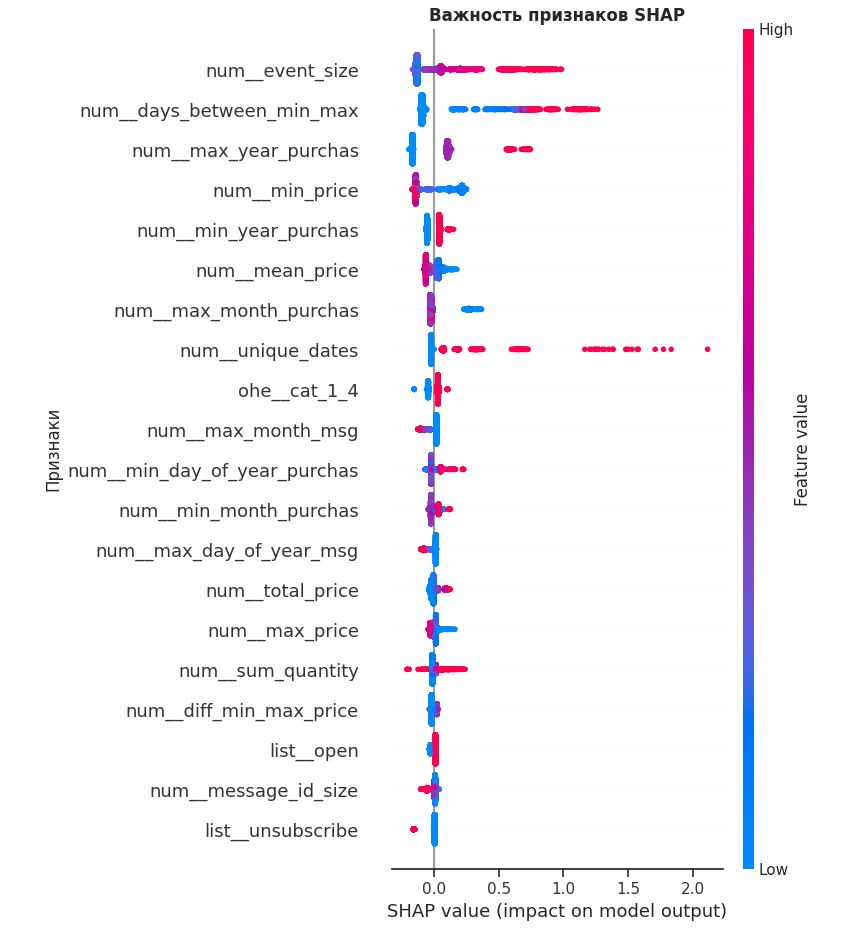





- `event_size` - количество всех событий, происходящих с маркетинговыми сообщениям;
- `days_between_min_max` - сколько прошло дней между первой и последней покупкой.
- `max_year_purchas` - год последний покупки;
- `min_price` - минимальная цена товара;
- `min_year_purchas` - год первой покупки;
- `mean_price` - средняя цена покупок;
- `max_month_purchas` - месяц последний покупки;
- `unique_dates` - кол-во уникальных дат покупок;
- `cat_1_4` - категория и субкатегория товаров;
- `max_month_msg` - месяц последнего маркетингового сообщения;
- `min_day_of_year_purchas` - день в году, когда была совершена первая покупка;
- `min_month_purchas` - месяц первой покупки;
- `max_day_of_year_purchas` - день в году, когда была совершена последняя покупка;
- `total_price` - общая сумма покупок;
- `max_price` - максимальная цена товара;
- `sum_quantity` - общее кол-во покупок;
- `diff_min_max_price` - разница между самой дорогой и дешевой покупкой;
- `open` - событие открытия сообщения;
- `message_id_size` - кол-во маркетинговых сообщений направленных покупателю; 
- `unsubscribe` -событие отписка от рассылки;


[Вернуться в начало тетрадки](#head)